# Machine Learning na Previsão do Tempo de Internato na UCI por Pneumonia

**CC4051 Machine Learning - Assigment 2**

**Grupo R:**
- Bárbara Simões Neto up202106176
- Beatriz Castro up202105723
- Rodrigo Couto up202104696

Neste trabalho, utilizamos o banco de dados MIMIC-III (Medical Information Mart for Intensive Care), um repositório com registos detalhados de pacientes críticos, incluindo dados demográficos, sinais vitais, exames laboratoriais e intervenções clínicas. Nosso objetivo é desenvolver um modelo de machine learning capaz de prever o tempo de internação na UCI em pacientes com pneumonia, seguindo um pipeline tradicional de análise de dados:

* Análise exploratória dos dados

* Pré-processamento: Limpeza e tratamento de dados ausentes, normalização e seleção de variáveis relevantes.

* Treino e validação: Aplicação de algoritmos de ML (random forests, gradient boosting e redes neurais) e avaliação por métricas como RMSE, MAE e R².

* Análise e interpretação: Identificação das variáveis mais influentes e comparação com evidências clínicas existentes.

As livrarias externas usadas para este trabalho foram: 
* pandas
* numpy
* datetime
* matplotlib
* seaborn
* sklearn

In [159]:
# Bibliotecas básicas e manipulação de dados
import pandas as pd
import numpy as np
from datetime import datetime
import time
from scipy.stats import wilcoxon

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e validação
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Métricas de avaliação
from sklearn.metrics import (
    accuracy_score, classification_report,
    r2_score, mean_squared_error, mean_absolute_error,
    precision_score, recall_score, f1_score
)
import shap

# Modelos de Regressão
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    AdaBoostRegressor
)
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Modelos de Classificação
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    AdaBoostClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Remover warnings
import warnings
warnings.filterwarnings("ignore")

As tabelas do MIMIC-III que escolhemos utilizar para prever o tempo de estadia na unidade de cuidados intensivos por parte de doentes que depois iremos filtrar para apenas os membros com pneumonia:
* **DIAGNOSES_ICD** – Contém diagnósticos codificados em ICD-9.
* **D_ICD_DIAGNOSES** – Dicionário de códigos ICD-9 (para mapear diagnósticos).
* **CHARTEVENTS** – Dados clínicos monitorizados (pressão arterial, saturação de O₂, etc.).
* **LABEVENTS** – Resultados de exames laboratoriais.
* **ADMISSIONS** – Informações sobre admissões hospitalares.
* **ICUSTAYS** – Tempo de internação na UTI (o target do seu modelo).
* **INPUTEVENTS_MV** – Medicamentos e fluidos administrados (via Método Volumétrico).
* **INPUTEVENTS_CV** – Medicamentos e fluidos administrados (via Método de Bomba de Infusão).
* **PATIENTS** – Dados demográficos dos pacientes (idade, sexo, etc.).
* **D_ITEMS** – Descrição dos itens em CHARTEVENTS.
* **D_LABITEMS** – Descrição dos itens em LABEVENTS.

In [ ]:
diagnoses = pd.read_csv('DIAGNOSES_ICD.csv')
d_icd = pd.read_csv('D_ICD_DIAGNOSES.csv')
chart_events = pd.read_csv('CHARTEVENTS.csv')
lab_events = pd.read_csv('LABEVENTS.csv')
admissions = pd.read_csv('ADMISSIONS.csv')
icustays = pd.read_csv('ICUSTAYS.csv')
inputevents_mv = pd.read_csv('INPUTEVENTS_MV.csv')
inputevents_cv = pd.read_csv('INPUTEVENTS_CV.csv')
patients = pd.read_csv('PATIENTS.csv')
d_items = pd.read_csv('D_ITEMS.csv')
labitems = pd.read_csv('D_LABITEMS.csv')

## **1.** Seleção da doença

Começamos por ver quais eram as doenças mais comuns como diagnóstico primário por parte dos doentes como um todo.

In [3]:
diagnoses_primary = diagnoses[diagnoses['SEQ_NUM'] == 1]

icd9_counts_primary = diagnoses_primary['ICD9_CODE'].value_counts()

icd9_counts_filtered = icd9_counts_primary[(icd9_counts_primary >= 400) & (icd9_counts_primary <= 1000)]

print(icd9_counts_filtered)

ICD9_CODE
V3101    998
486      725
5070     659
4280     570
4240     568
430      529
5849     526
41041    482
41011    482
5789     446
Name: count, dtype: int64


Códigos ICD9 começados por V correspondem a acidentes com veículos. Por isso fomos analisar o segundo caso mais comum, com 725 casos, o diagnótico cujo código é 486.

In [4]:
diagnoses_inf = diagnoses[diagnoses['ICD9_CODE'] == '486']

disease_info = d_icd[d_icd['ICD9_CODE'] == '486']  
print(disease_info[['ICD9_CODE', 'SHORT_TITLE', 'LONG_TITLE']])

count_seq1 = diagnoses_inf[diagnoses_inf['SEQ_NUM'] == 1].shape[0]
print(count_seq1)

     ICD9_CODE              SHORT_TITLE                       LONG_TITLE
5147       486  Pneumonia, organism NOS  Pneumonia, organism unspecified
725


O código 486 corresponde, então, ao diagnóstico de pneumonia. 

Com base no id do diagnóstico escolhido criámos uma tabela, a partir da DIAGNOSES_ICD e ICUSTAYS com as colunas:
* **SUBJECT_ID** - id do paciente
* **HADM_ID** - id da admissao no hospital por parte do paciente
* **ICUSTAY_ID** - id da estadia na UTI por parte do paciente
* **ICD9_CODE** - 486, pneumonia, código do diagnóstico primário do paciente


A coluna ICUSTAY_ID foi obtida através da junção à esquerda da tabela DIAGNOSES_ICD com ICUSTAY tendo como chave de junção as colunas SUBJECT_ID e HADM_ID, ou seja, quando a pessoa  (subject) foi admitida (hadm) num hospital com pneumonia como primeiro diagnóstico e ficou internada na UCI.

In [5]:
diagnoses_inf = diagnoses[(diagnoses['ICD9_CODE'] == '486') & (diagnoses['SEQ_NUM'] == 1)]


tabela = diagnoses_inf[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']]

hadm_ids = tabela['HADM_ID'].unique()
subject_ids = tabela['SUBJECT_ID'].unique()

icustays = icustays[icustays['HADM_ID'].isin(hadm_ids)]


tabela = icustays.merge(
    tabela,
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)

primeira_tabela = tabela[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ICD9_CODE']] 


print(primeira_tabela.shape)  
primeira_tabela

(763, 4)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ICD9_CODE
0,346,195392,260798,486
1,111,192123,254245,486
2,242,192980,270389,486
3,357,117876,235292,486
4,368,105889,242607,486
...,...,...,...,...
758,97399,121321,212639,486
759,91867,106929,297547,486
760,99185,150608,275520,486
761,90688,107472,213932,486


De seguida, filtrámos as outras tabelas retringindo aos ICUSTAY_IDs obtidos anteriormente, ou, no caso das tabelas LABEVENTS, ADMISSIONS e PATIENTS que não pussuem esta coluna, restringimos pelo ID a admissão ou do paciente.

In [6]:
hadm_ids = tabela['HADM_ID'].unique()
icu_ids = tabela['ICUSTAY_ID'].unique()
subject_ids = tabela['SUBJECT_ID'].unique()

chart_events_filtered = chart_events[chart_events['ICUSTAY_ID'].isin(icu_ids)]
lab_events_filtered = lab_events[lab_events['HADM_ID'].isin(hadm_ids)]
admissions_filtered = admissions[admissions['HADM_ID'].isin(hadm_ids)]
icustays_filtered = icustays[icustays['ICUSTAY_ID'].isin(icu_ids)]
inputevents_mv_filtered = inputevents_mv[inputevents_mv['ICUSTAY_ID'].isin(icu_ids)]
inputevents_cv_filtered = inputevents_cv[inputevents_cv['ICUSTAY_ID'].isin(icu_ids)]
patients_filtered = patients[patients['SUBJECT_ID'].isin(subject_ids)]

In [ ]:
chart_events_filtered.to_csv('chart_events_filtered.csv', index=False)
lab_events_filtered.to_csv('lab_events_filtered.csv', index=False)
admissions_filtered.to_csv('admissions_filtered.csv', index=False)
icustays_filtered.to_csv('icustays_filtered.csv', index=False)
inputevents_mv_filtered.to_csv('inputevents_mv_filtered.csv', index=False)
inputevents_cv_filtered.to_csv('inputevents_cv_filtered.csv', index=False)
patients_filtered.to_csv('patients_filtered.csv', index=False)

chart_events = pd.read_csv('chart_events_filtered.csv')
lab_events = pd.read_csv('lab_events_filtered.csv')
admissions = pd.read_csv('admissions_filtered.csv')
icustays = pd.read_csv('icustays_filtered.csv')
inputevents_mv = pd.read_csv('inputevents_mv_filtered.csv')
inputevents_cv = pd.read_csv('inputevents_cv_filtered.csv')
input_mv = pd.read_csv('inputevents_mv_filtered.csv')
input_cv = pd.read_csv('inputevents_cv_filtered.csv')
patients = pd.read_csv('patients_filtered.csv')

## **2.** Análise Exploratória dos Dados

### a. ICUSTAYS

Fizemos análise da distribuição temporal da estadia na Unidade de Cuidados Intensivos por parte dos pacientes com pneumonia.

In [160]:
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])
icustays['LOS'] = (icustays['OUTTIME'] - icustays['INTIME']).dt.total_seconds() / 3600 / 24

# Basic Descriptive Analysis
print("=== STATISTICAL SUMMARY ===")
print(f"Total ICU admissions: {len(icustays)}")
print(f"Intensive care units represented: {icustays['LAST_CAREUNIT'].nunique()}")
print("\nLength of Stay distribution (days):")
print(icustays['LOS'].describe())

=== STATISTICAL SUMMARY ===
Total ICU admissions: 763
Intensive care units represented: 5

Length of Stay distribution (days):
count    763.000000
mean       3.861453
std        4.755012
min        0.027951
25%        1.211753
50%        2.141609
75%        4.270422
max       41.557639
Name: LOS, dtype: float64


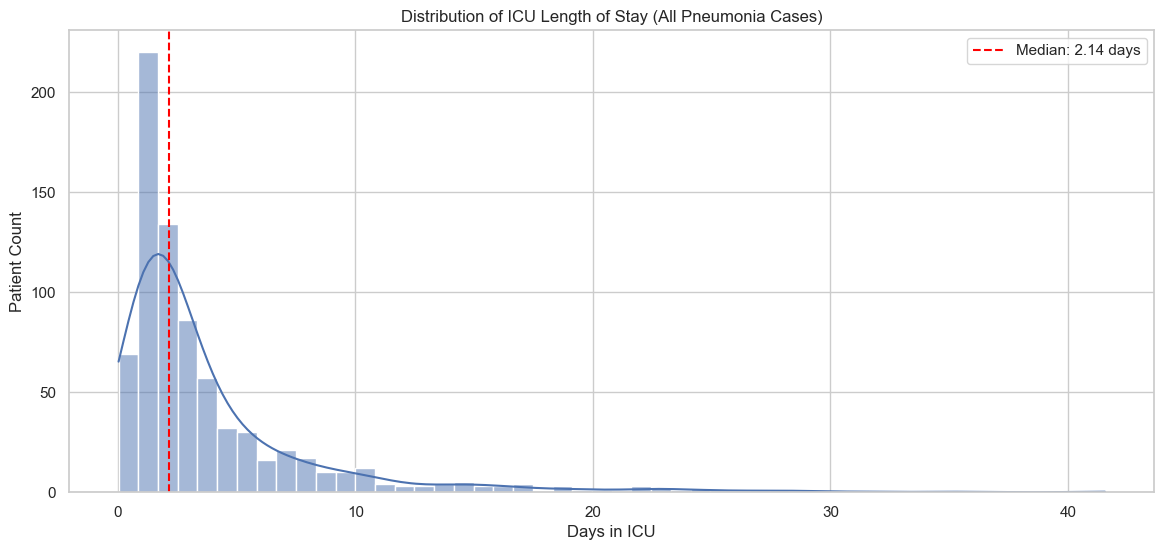

In [161]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.figure(figsize=(14, 6))
sns.histplot(data=icustays, x='LOS', bins=50, kde=True)
plt.title('Distribution of ICU Length of Stay (All Pneumonia Cases)')
plt.xlabel('Days in ICU')
plt.ylabel('Patient Count')
plt.axvline(x=icustays['LOS'].median(), color='red', linestyle='--', label=f'Median: {icustays["LOS"].median():.2f} days')
plt.legend()
plt.show()

A figura apresenta a distribuição do tempo de estadia na Unidade de Cuidados Intensivos (UCI) para os casos de pneumonia. Observa-se que a maioria dos doentes permanece na UCI por poucos dias, com um pico de frequência entre 1 e 2 dias. A mediana da duração é de 2,14 dias, representada pela linha tracejada vermelha. A distribuição é assimétrica à direita, com alguns casos mais longos, chegando a um máximo de aproximadamente 42 dias.

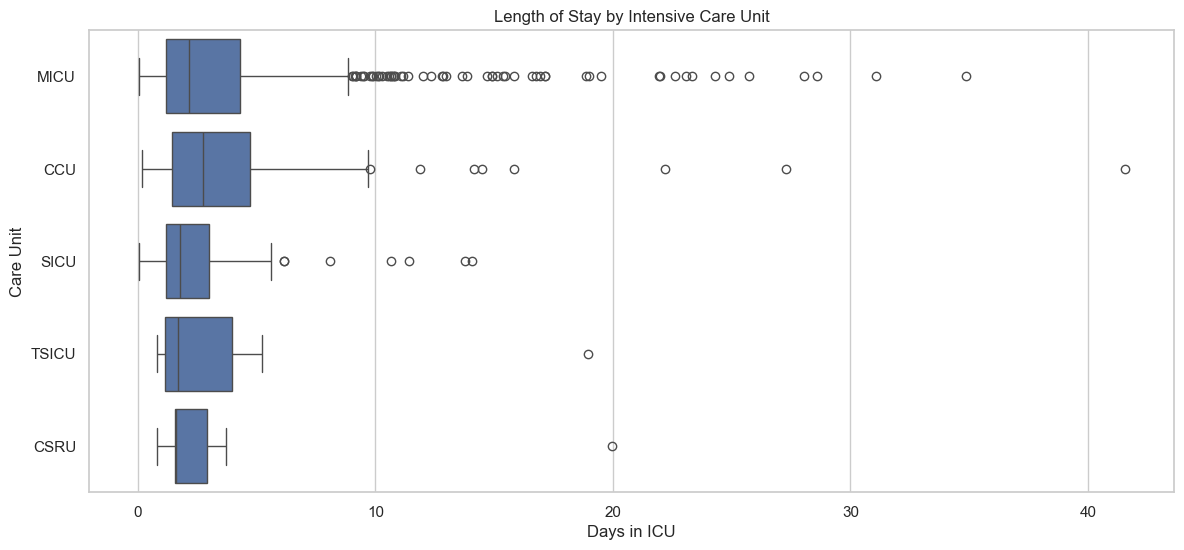

In [162]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=icustays, x='LOS', y='LAST_CAREUNIT', order=icustays['LAST_CAREUNIT'].value_counts().index)
plt.title('Length of Stay by Intensive Care Unit')
plt.xlabel('Days in ICU')
plt.ylabel('Care Unit')
plt.show()

Nesta figura de box-plots que mostram a distribuição do tempo nas respetivas unidades de cuidados intensivos (ICU), observa-se que a MICU tem a maior variabilidade no tempo de internamento, com diversos casos extremos acima dos 20 dias. A maioria das unidades apresenta uma mediana inferior a 5 dias, sendo que a CSRU tem a menor mediana e dispersão. No entanto, as diferenças entre os box-plots parecem pouco significativas, o que nos leva a dizer que o tipo de unidade pouco ou nada influencia no tempo de internato.

Fizemos também uma análise sazonal dos casos de pneumonia.

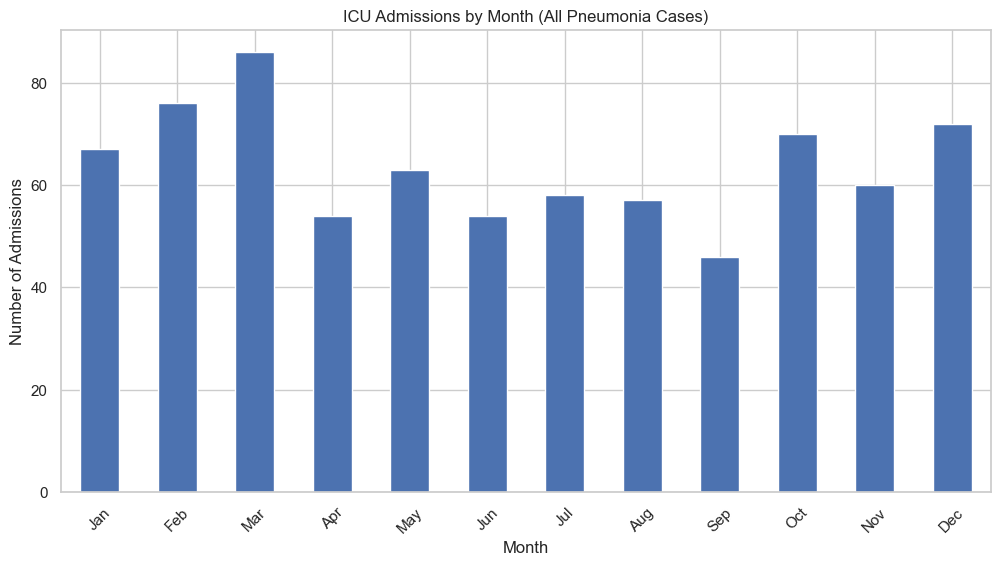

In [163]:
icustays['ADMIT_MONTH'] = icustays['INTIME'].dt.month
monthly_admits = icustays['ADMIT_MONTH'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
monthly_admits.plot(kind='bar')
plt.title('ICU Admissions by Month (All Pneumonia Cases)')
plt.xlabel('Month')
plt.ylabel('Number of Admissions')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

Já esta figura compara o número de internamentos por mês em cuidados intensivos por pneumonia. Verifica-se um pico de admissões nos meses de inverno, com março a registar o maior número de casos. Os meses de setembro e abril apresentam os valores mais baixos. Esta tendência sugere uma maior incidência de pneumonia grave nos meses mde mais frio, com implicações na preparação sazonal dos serviços de saúde.

### b. INPUTEVENTS 

De seguida exploramos as tabelas dos INPUTEVENTS

In [164]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [14, 8]

#Juntar input events com nomes das medicações
input_events = pd.concat([inputevents_cv, inputevents_mv]).merge(
    d_items[['ITEMID', 'LABEL']].drop_duplicates(), 
    on='ITEMID', 
    how='left'
)

#Criar os intervalos de tempo
input_events['CHARTTIME'] = pd.to_datetime(input_events['CHARTTIME'])
input_events['STARTTIME'] = pd.to_datetime(input_events['STARTTIME'])
input_events['time'] = input_events['CHARTTIME'].fillna(input_events['STARTTIME'])


print("=== INPUT EVENTS ANALYSIS ===")
print(f"Total medication administrations: {len(input_events):,}")
print(f"Unique medication items: {input_events['ITEMID'].nunique()}")

top_items = (input_events['ITEMID'].value_counts()
            .reset_index(name='COUNT')
            .rename(columns={'index': 'ITEMID'})
            .head(10))

top_items_with_labels = top_items.merge(
    d_items[['ITEMID', 'LABEL']].drop_duplicates(),
    on='ITEMID',
    how='left'
)


=== INPUT EVENTS ANALYSIS ===
Total medication administrations: 191,612
Unique medication items: 273


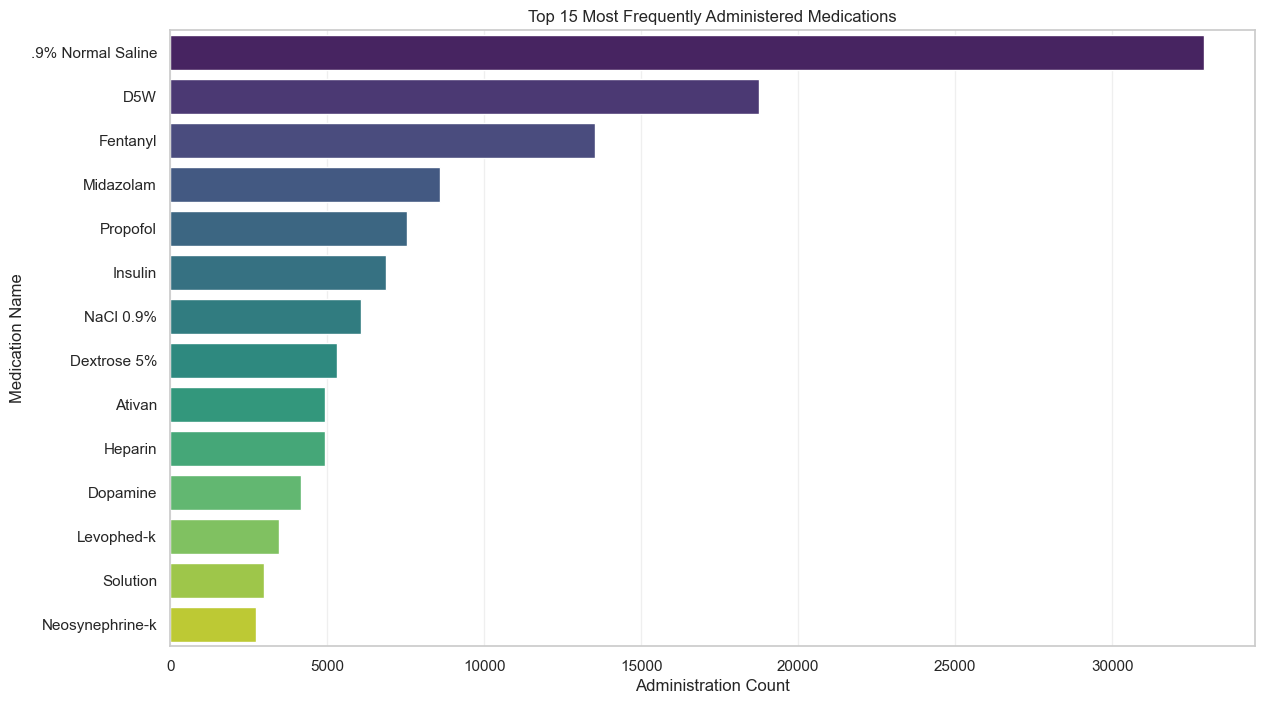

In [165]:
top_item_ids = input_events['ITEMID'].value_counts().head(15).index
top_items_with_labels = input_events[input_events['ITEMID'].isin(top_item_ids)]

plt.figure(figsize=(14, 8))
sns.countplot(
    data=top_items_with_labels,
    y='LABEL',
    order=top_items_with_labels['LABEL'].value_counts().index,
    palette='viridis'
)
plt.title('Top 15 Most Frequently Administered Medications')
plt.xlabel('Administration Count')
plt.ylabel('Medication Name')
plt.grid(True, axis='x', alpha=0.3)
plt.show()

O gráfico apresenta os 15 medicamentos mais frequentemente administrados em contexto de cuidados intensivos. O soro fisiológico a 0,9% (.9% Normal Saline) é o mais utilizado, com uma larga vantagem face aos restantes, seguido da solução glicosada D5W e do analgésico Fentanil. Também se destacam sedativos como o Midazolam e o Propofol, bem como insulina e anticoagulantes como a heparina. Estes dados refletem as necessidades clínicas típicas de suporte intensivo no caso da pneumonia.

Criamos os histogramas da distribuição da administração dos 6 medicamentos mais usados ao longo do dia.

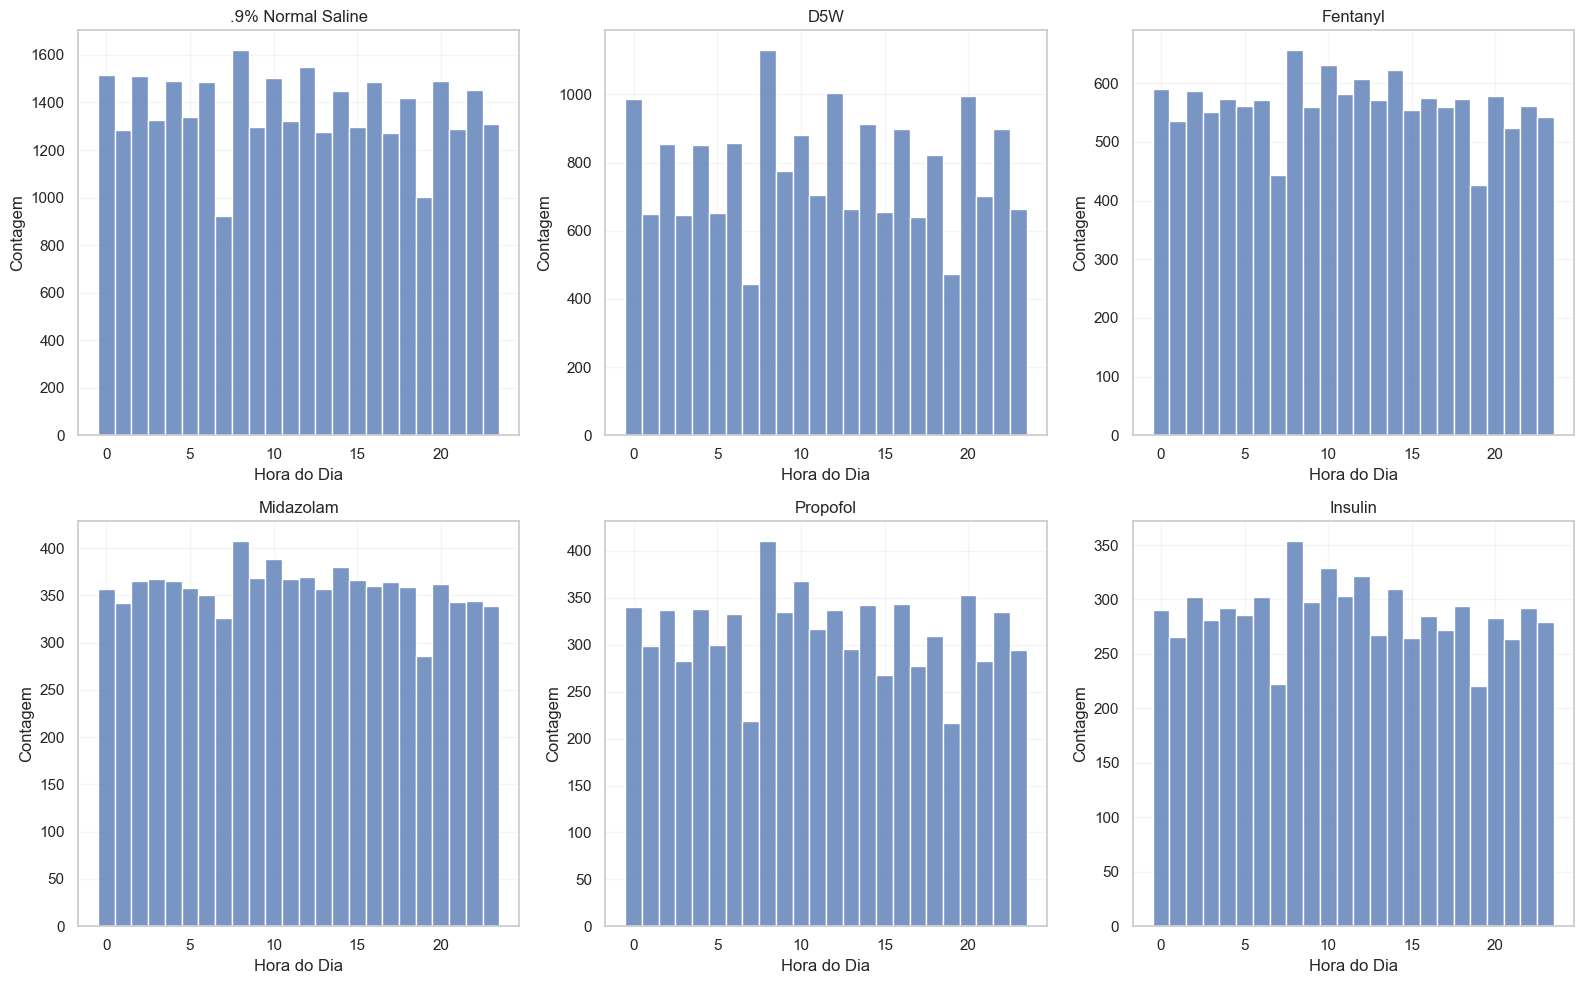

In [166]:
top_items_with_labels['CHARTTIME'] = pd.to_datetime(top_items_with_labels['CHARTTIME'])

top_items_with_labels['hour'] = top_items_with_labels['CHARTTIME'].dt.hour

plt.figure(figsize=(16, 10))
top_6_labels = top_items_with_labels['LABEL'].value_counts().index[:6]

for i, item_label in enumerate(top_6_labels):
    plt.subplot(2, 3, i+1)
    item_data = top_items_with_labels[top_items_with_labels['LABEL'] == item_label]
    sns.histplot(data=item_data, x='hour', bins=24, discrete=True)
    plt.title(f'{item_label[:30]}' + ('...' if len(item_label) > 30 else ''))
    plt.xlabel('Hora do Dia')
    plt.ylabel('Contagem')
    plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

A figura apresenta a distribuição da administração dos seis medicamentos mais utilizados ao longo do dia. O soro fisiológico (.9% Normal Saline), como ja visto, é o mais frequentemente administrado, com uma distribuição relativamente constante ao longo das 24 horas. O D5W apresenta uma maior variação, com picos notáveis por volta das 10h. Fentanil, Midazolam, Propofol e Insulina mostram padrões semelhantes, com maior concentração entre as 8h e 14h, sugerindo maior atividade clínica neste intervalo.

### c. LABEVENTS

Fizemos visualizações para fazer uma análise visual da tabela dos LABEVENTS.

In [167]:
labevents = lab_events.merge(
    labitems[['ITEMID', 'LABEL', 'FLUID', 'CATEGORY']].drop_duplicates(),
    on='ITEMID',
    how='left'
)

# Convert timestamps (adjust column names as needed)
if 'CHARTTIME' in labevents.columns:
    labevents['CHARTTIME'] = pd.to_datetime(labevents['CHARTTIME'])
    labevents['time'] = labevents['CHARTTIME']

# Basic Descriptive Analysis
print("=== LAB EVENTS ANALYSIS ===")
print(f"Total lab tests performed: {len(labevents):,}")
print(f"Unique lab test items: {labevents['ITEMID'].nunique()}")

# Get top lab tests with counts and labels
top_labtests = (labevents['ITEMID'].value_counts()
               .reset_index(name='COUNT')
               .rename(columns={'index': 'ITEMID'})
               .head(10)
               .merge(labitems[['ITEMID', 'LABEL', 'CATEGORY']].drop_duplicates(),
                    on='ITEMID',
                    how='left'))


=== LAB EVENTS ANALYSIS ===
Total lab tests performed: 278,197
Unique lab test items: 475


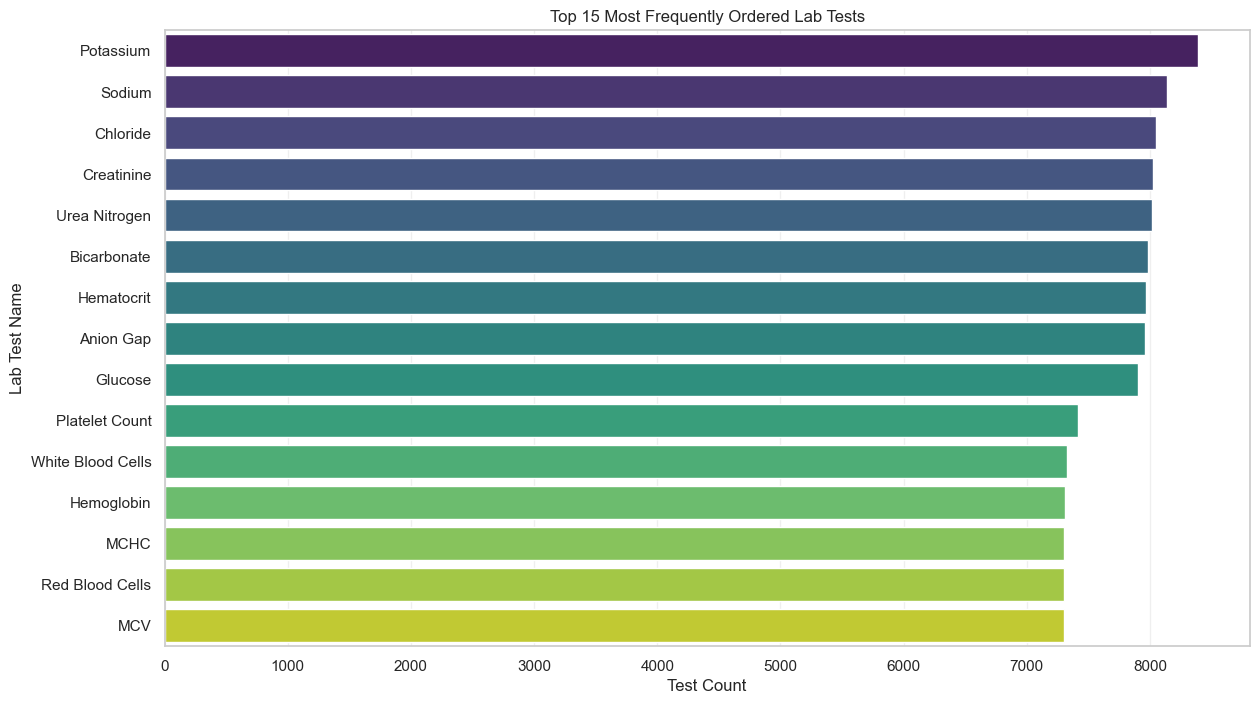

In [168]:
top_labtest_ids = labevents['ITEMID'].value_counts().head(15).index
top_labtests_with_labels = labevents[labevents['ITEMID'].isin(top_labtest_ids)]

plt.figure(figsize=(14, 8))
sns.countplot(
    data=top_labtests_with_labels,
    y='LABEL',
    order=top_labtests_with_labels['LABEL'].value_counts().index,
    palette='viridis'
)
plt.title('Top 15 Most Frequently Ordered Lab Tests')
plt.xlabel('Test Count')
plt.ylabel('Lab Test Name')
plt.grid(True, axis='x', alpha=0.3)
plt.show()

Agora nos testes laboratoriais mais frequentemente utilizados, vemos que os mesmos relacionados ao equilíbrio eletrolítico e função renal, como Potássio, Sódio, Cloro e Creatinina lideram . Também é de se destacar exames como Hematócrito, Hemoglobina, Glóbulos Brancos e Contagem de Plaquetas, que são fundamentais para a avaliação do estado hematológico e resposta inflamatória dos doentes.

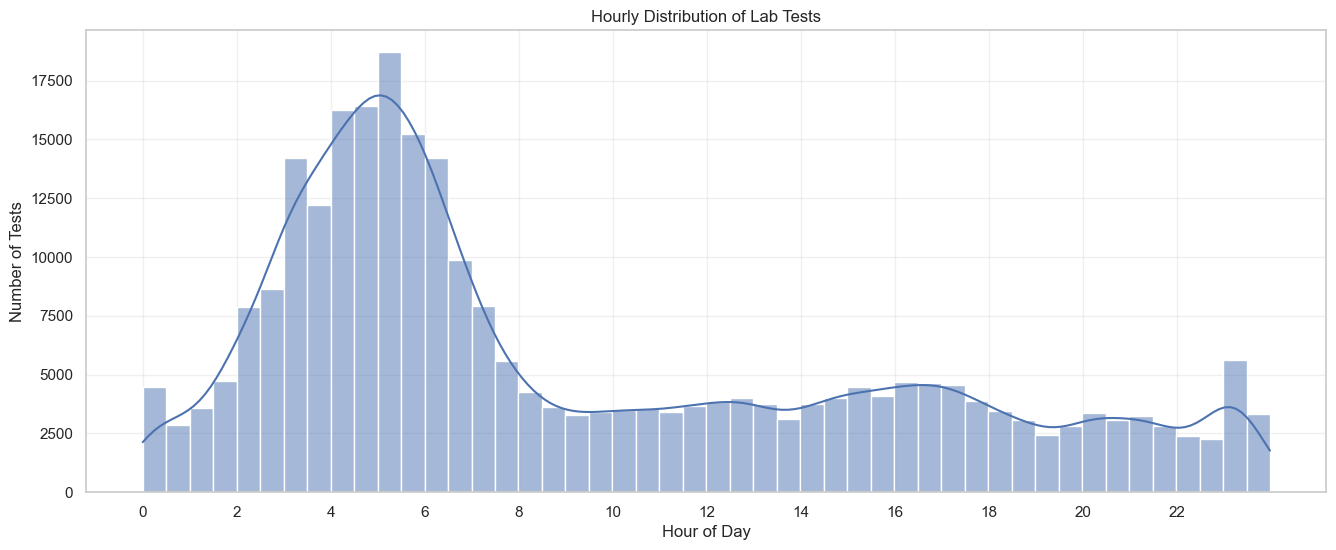

In [169]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [14, 8]

if 'time' in labevents.columns:
    labevents['hour'] = labevents['time'].dt.hour + labevents['time'].dt.minute/60
    
    plt.figure(figsize=(16, 6))
    sns.histplot(data=labevents, x='hour', bins=48, kde=True)
    plt.title('Hourly Distribution of Lab Tests')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Tests')
    plt.xticks(np.arange(0, 24, 2))
    plt.grid(True, alpha=0.3)
    plt.show()

Vendo agora a distribuição da quantidade de testes laborais realizados ao longo do dia, nota-se um pico pronunciado entre as 4h e as 7h da manhã, com o número de testes a diminuir significativamente a partir das 8h. Após este período, a frequência mantém-se relativamente estável, com ligeiros aumentos durante a tarde e início da noite. Estes valores sugerem que a extração de informação é feita antes das rondas médicas matinais.

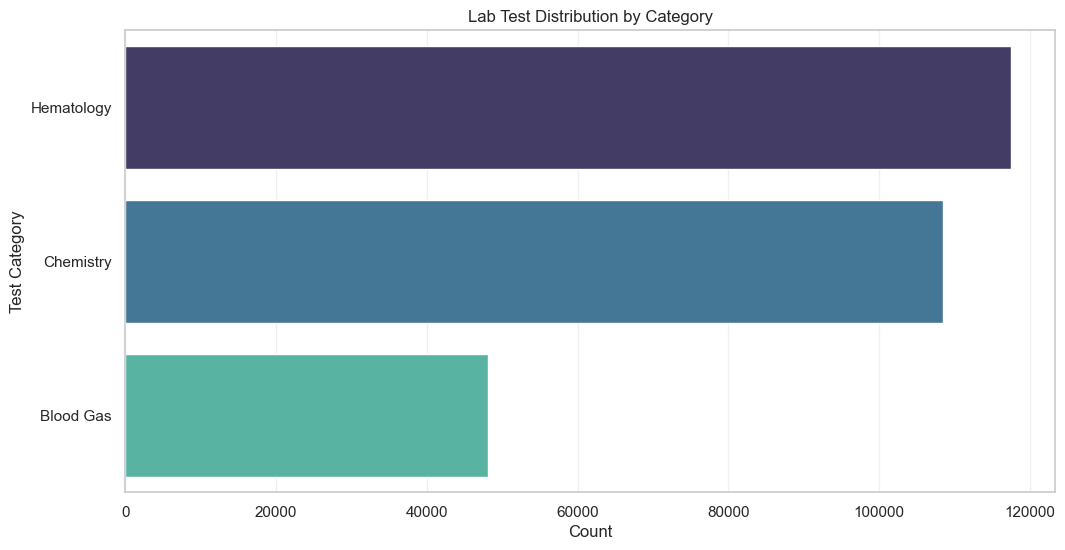

In [170]:
top3 = labevents['CATEGORY'].value_counts().nlargest(3).index

plt.figure(figsize=(12, 6))
sns.countplot(
    data=labevents[labevents['CATEGORY'].isin(top3)],
    y='CATEGORY',
    order=top3,
    palette='mako'
)
plt.title('Lab Test Distribution by Category')
plt.xlabel('Count')
plt.ylabel('Test Category')
plt.grid(True, axis='x', alpha=0.3)
plt.show()

A figura mostra a distribuição dos principais testes laboratoriais utilizados em casos de pneumonia em unidades de cuidados intensivos. As três categorias representadas — Hematology, Chemistry e Blood Gas — correspondem aos exames laboratoriais mais comuns neste contexto clínico, sendo fundamentais para o diagnóstico, monitorização e gestão do estado clínico dos doentes com pneumonia grave.

### d. PATIENTS

Escolhemos analisar apenas um paciente porque apenas tornava-se repetitivo fazer de mais e como temos por prinicipal objetivo tirar conclusões sobre casos de pneumonia, assumimos que certas nuânces vão se encontrar em todos os casos. O paciente escolhido corresponde ao ID 370, que apresenta um tempo de internato muito proximo da média e tem dados sufecientes para esta análise.

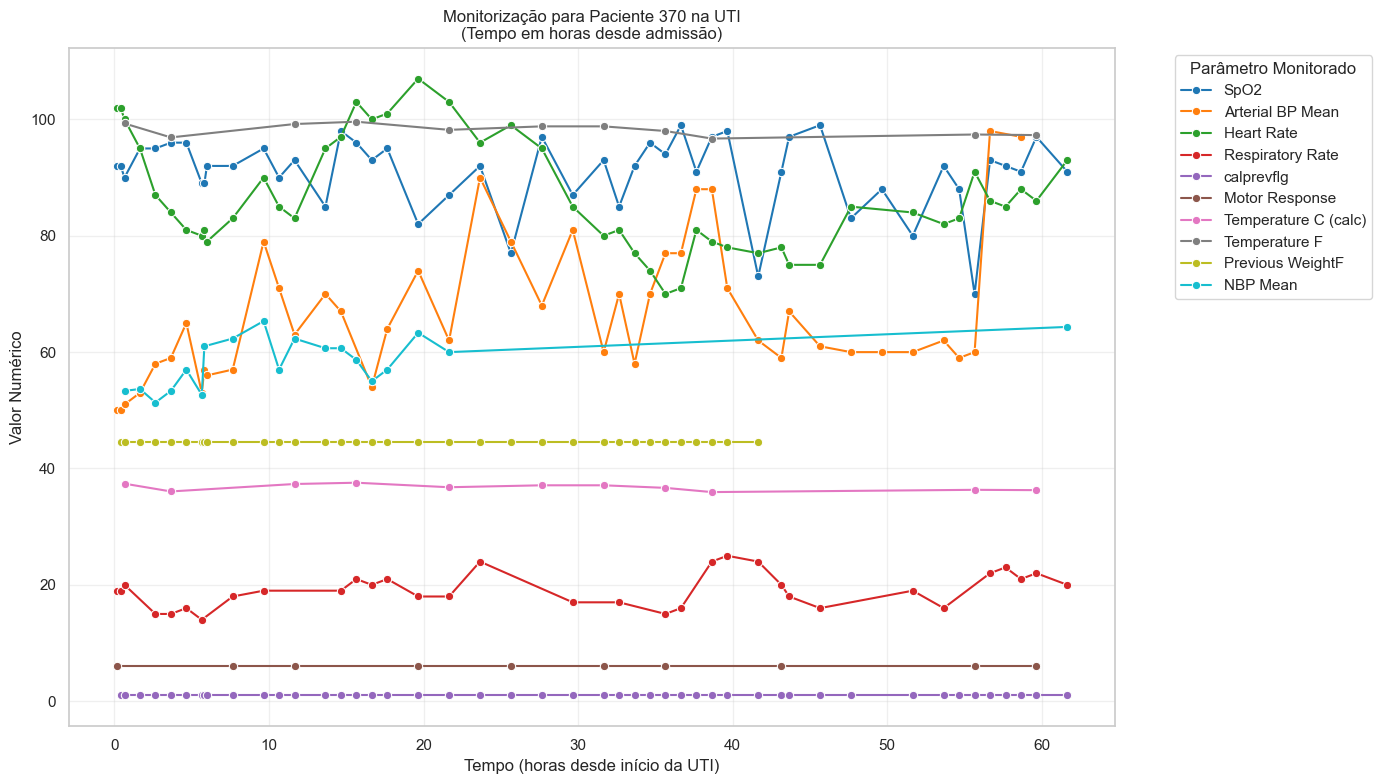

In [171]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [14, 8]

subject_id = 370
hadm_id = 123421
icustay_id = 228402

def convert_time_hours(df, time_col):
    df[time_col] = pd.to_datetime(df[time_col])
    df['hours_since_start'] = (df[time_col] - df[time_col].min()).dt.total_seconds() / 3600
    return df

# Filtrar eventos para o paciente desejado
charts = chart_events[
    (chart_events['SUBJECT_ID'] == subject_id) & 
    (chart_events['HADM_ID'] == hadm_id) & 
    (chart_events['ICUSTAY_ID'] == icustay_id)
]

if not charts.empty:
    charts = convert_time_hours(charts, 'CHARTTIME')
    
    charts_numeric = charts.dropna(subset=['VALUENUM'])

    charts_numeric = charts_numeric.merge(d_items[['ITEMID', 'LABEL']], on='ITEMID', how='left')

    # Selecionar os 10 sinais mais frequentes
    top_items = charts_numeric['ITEMID'].value_counts().head(10).index
    charts_top = charts_numeric[charts_numeric['ITEMID'].isin(top_items)]

    plt.figure(figsize=(14, 8))
    sns.lineplot(
        data=charts_top, 
        x='hours_since_start', 
        y='VALUENUM', 
        hue='LABEL',        
        palette='tab10',
        marker='o'
    )
    plt.title(f'Monitorização para Paciente {subject_id} na UTI\n(Tempo em horas desde admissão)')
    plt.xlabel('Tempo (horas desde início da UTI)')
    plt.ylabel('Valor Numérico')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Parâmetro Monitorado')
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

else:
    print("Nenhum dado encontrado para esse paciente.")

O paciente 370 durante a sua estadia na UTI, ao longo de aproximadamente 62 horas. Observa-se que a saturação de oxigénio (SpO2) se manteve relativamente estável, tal como a temperatura corporal. Já a pressão arterial média e a frequência respiratória mostraram variações moderadas, dados estes que fazem sentido consoante a causa do internato do paciente.

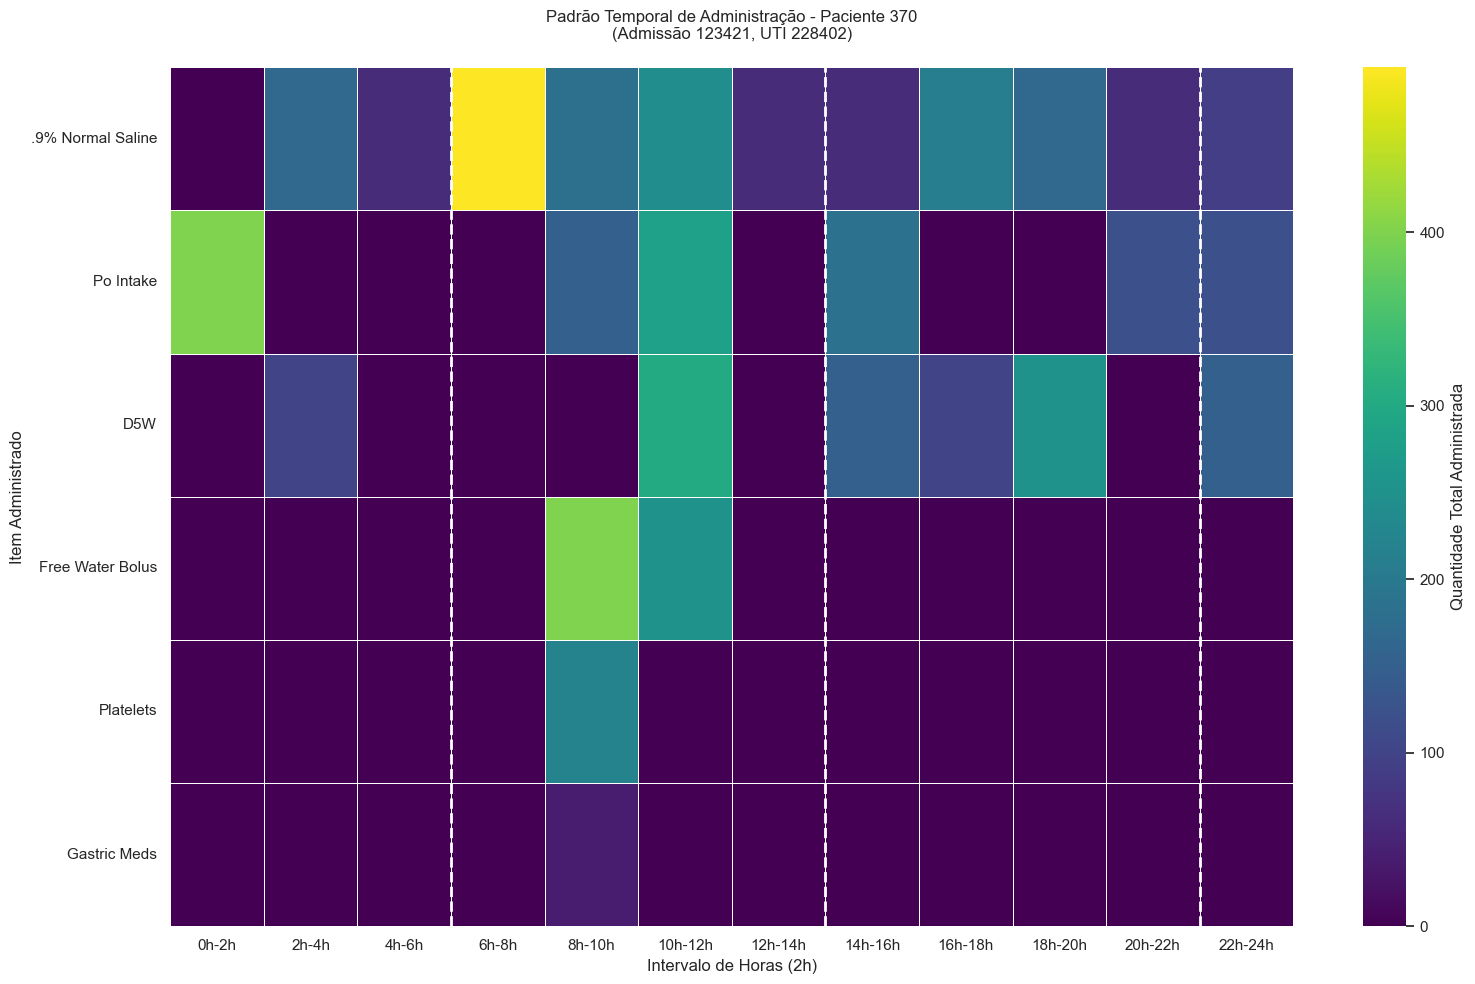


Itens administrados por turno:
shift              Manhã (0-8h)  Tarde (8-16h)  Noite (16-24h)
LABEL                                                         
.9% Normal Saline         870.0          600.0           315.0
D5W                       100.0          550.0           400.0
Free Water Bolus          400.0          250.0             0.0
Gastric Meds               40.0            0.0             0.0
Platelets                   0.0          221.0             0.0
Po Intake                 150.0          465.0           240.0


In [172]:
def convert_time(df, time_col):
    df[time_col] = pd.to_datetime(df[time_col])
    df['hour'] = df[time_col].dt.hour + df[time_col].dt.minute / 60
    return df

# Juntando os dados CV e MV para o paciente
input_events = pd.concat([
    inputevents_cv[
        (inputevents_cv['SUBJECT_ID'] == subject_id) & 
        (inputevents_cv['HADM_ID'] == hadm_id) & 
        (inputevents_cv['ICUSTAY_ID'] == icustay_id)
    ],
    inputevents_mv[
        (inputevents_mv['SUBJECT_ID'] == subject_id) & 
        (inputevents_mv['HADM_ID'] == hadm_id) & 
        (inputevents_mv['ICUSTAY_ID'] == icustay_id)
    ]
])

if not input_events.empty:
    input_events = convert_time(input_events, 'CHARTTIME' if 'CHARTTIME' in input_events.columns else 'STARTTIME')
    input_events['hour_bin'] = (input_events['hour'] // 2) * 2

    # Merge com d_items para obter os LABELs
    input_events = input_events.merge(d_items[['ITEMID', 'LABEL']], on='ITEMID', how='left')

    # Pivot para heatmap com LABEL no eixo Y
    heatmap_data = input_events.pivot_table(
        index='LABEL',                   # <-- Substitui ITEMID por LABEL
        columns='hour_bin',
        values='AMOUNT',
        aggfunc='sum',
        fill_value=0
    )
    
    heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values(ascending=False).index]
    
    hour_bins = sorted(input_events['hour_bin'].unique())
    hour_labels = [f"{int(h)}h-{int(h)+2}h" for h in hour_bins]
    
    plt.figure(figsize=(16, 10))
    sns.heatmap(
        heatmap_data,
        cmap='viridis',
        cbar_kws={'label': 'Quantidade Total Administrada'},
        linewidths=0.5,
        xticklabels=hour_labels
    )
    
    plt.title(f'Padrão Temporal de Administração - Paciente {subject_id}\n(Admissão {hadm_id}, UTI {icustay_id})', pad=20)
    plt.xlabel('Intervalo de Horas (2h)')
    plt.ylabel('Item Administrado')
    plt.yticks(rotation=0)
    
    for shift in [8, 16, 24]:
        bin_position = (shift // 2) - 1
        if bin_position < len(hour_bins):
            plt.axvline(x=bin_position, color='white', linestyle='--', linewidth=2)
    
    plt.tight_layout()
    plt.show()
    
    # Estatísticas por turno com LABEL no lugar de ITEMID
    print("\nItens administrados por turno:")
    input_events['shift'] = pd.cut(input_events['hour'], 
                                   bins=[0, 8, 16, 24], 
                                   labels=['Manhã (0-8h)', 'Tarde (8-16h)', 'Noite (16-24h)'])
    
    print(input_events.groupby(['LABEL', 'shift'])['AMOUNT'].sum().unstack().fillna(0))

else:
    print("Nenhum dado de administração encontrado para este paciente.")

O paciente recebeu maior volume de fluidos e medicamentos durante o dia, com picos de soro fisiológico pela manhã e dextrose à tarde. Intervenções específicas como plaquetas e medicação gástrica ocorreram em horários determinados, enquanto a noite apresentou, no geral, uma menor atividade terapêutica.

## **3.** Pré-processamento

Com base no id do diagnóstico escolhido criámos uma tabela, a partir da DIAGNOSES_ICD e ICUSTAYS com as colunas:
* **SUBJECT_ID** - id do paciente
* **HADM_ID** - id da admissão no hospital por parte do paciente
* **ICUSTAY_ID** - id da estadia na UTI por parte do paciente
* **ICD9_CODE** - 486, pneumonia, código do diagnóstico primário do paciente
* **ICD9_CODE_2** - Código do diagnóstico secundário do paciente
* **ICD9_CODE_3** - Código do diagnóstico terciário do paciente
* **FIRST_CAREUNIT** -  Unidade de cuidados intensivos (UCI) onde o paciente foi inicialmente internado
* **LAST_CAREUNIT** - Última UCI onde o paciente esteve antes da alta ou transferência 
* **LOS** - Tempo que o paciente esteve internado na UTI  

**Processo de construção:**

A coluna ICUSTAY_ID foi obtida através da junção à esquerda da tabela DIAGNOSES_ICD com ICUSTAY tendo como chave de junção as colunas SUBJECT_ID e HADM_ID, ou seja, quando a pessoa  (subject) foi admitida (hadm) num hospital com pneumonia como primeiro diagnóstico e ficou internada na UCI.

**Objetivo:**

Ficar apenas com as colunas necessárias para identificação de cada caso e colunas que podem ser informativas para modelos finais.

In [128]:
diagnoses_inf = diagnoses[(diagnoses['ICD9_CODE'] == '486') & (diagnoses['SEQ_NUM'] == 1)]
diagnoses_seq2 = diagnoses[diagnoses['SEQ_NUM'] == 2][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']].rename(columns={'ICD9_CODE': 'ICD9_CODE_2'})
diagnoses_seq3 = diagnoses[diagnoses['SEQ_NUM'] == 3][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']].rename(columns={'ICD9_CODE': 'ICD9_CODE_3'})

merged = diagnoses_inf.merge(diagnoses_seq2, on=['SUBJECT_ID', 'HADM_ID'], how='left')
merged = merged.merge(diagnoses_seq3, on=['SUBJECT_ID', 'HADM_ID'], how='left')
tabela = merged[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE', 'ICD9_CODE_2', 'ICD9_CODE_3']]

hadm_ids = tabela['HADM_ID'].unique()
subject_ids = tabela['SUBJECT_ID'].unique()


tabela = icustays.merge(
    tabela,
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)

tabela = tabela[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ICD9_CODE', 'ICD9_CODE_2', 'ICD9_CODE_3', 'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'LOS']] 

tabela

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ICD9_CODE,ICD9_CODE_2,ICD9_CODE_3,FIRST_CAREUNIT,LAST_CAREUNIT,LOS
0,346,195392,260798,486,42731,4241,MICU,MICU,4.854479
1,111,192123,254245,486,49121,4139,CCU,MICU,10.570833
2,242,192980,270389,486,496,51889,MICU,MICU,1.701389
3,357,117876,235292,486,3453,5722,SICU,SICU,14.064063
4,368,105889,242607,486,49121,41071,MICU,MICU,4.906979
...,...,...,...,...,...,...,...,...,...
758,97399,121321,212639,486,42823,5845,MICU,MICU,5.687755
759,91867,106929,297547,486,51881,1970,MICU,MICU,2.886759
760,99185,150608,275520,486,5849,49121,MICU,MICU,1.141921
761,90688,107472,213932,486,5849,2930,MICU,MICU,2.348021


Com base nos dados de medicamentos (INPUTEVENTS_CV e INPUTEVENTS_MV) criámos uma tabela estruturada da seguinte forma:

* **ICUSTAY_ID** - id da estadia na UTI (chave principal)
* **input_item_[ID]** - 20 colunas indicando se cada medicamento/fluido foi administrado ou não, e no caso positivo o número e referente à quantidade de vezes ele foi usado.

**Processo de construção:**

Combinámos INPUTEVENTS_CV e INPUTEVENTS_MV e selecionámos os 20 itens (medicamentos/fluidos) mais utilizados. De seguida, criámos indicadores inteiros para cada item por internamento.

**Objetivo:**

Estas variéveis permitem analisar como os padrões de medicação se relacionam com o tempo de internamento na UTI, servindo como base para modelos preditivos.

In [129]:
cols_comuns = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'AMOUNT', 'AMOUNTUOM']


input_combined = pd.concat([input_cv, input_mv], ignore_index=True)


item_usage_counts = (
    input_combined[['ICUSTAY_ID', 'ITEMID']]
    .drop_duplicates()
    .groupby('ITEMID')
    .size()
    .sort_values(ascending=False)
)

top_20_items = item_usage_counts.head(20).index.tolist()
selected_items = top_20_items


filtered = input_combined[
    (input_combined['ITEMID'].isin(selected_items)) &
    (input_combined['ICUSTAY_ID'].isin(icu_ids))
].copy()


filtered['USED'] = 1

pivot = (
    filtered
    .groupby(['ICUSTAY_ID', 'ITEMID'])['USED']
    .count()  
    .unstack(fill_value=0)
)


pivot = pivot.reindex(columns=selected_items, fill_value=0)
pivot = pivot.reindex(index=icu_ids, fill_value=0)  


pivot.columns = [f'input_item_{col}' for col in pivot.columns]
pivot = pivot.reset_index()


icustays_unique = icustays.drop_duplicates(subset=['ICUSTAY_ID'], keep='first')
tabela = pivot.merge(
    tabela,
    on='ICUSTAY_ID',
    how='left'  
)

tabela

,ICUSTAY_ID,input_item_225158,input_item_220949,input_item_30013,input_item_226452,input_item_30018,input_item_30056,input_item_225798,input_item_225975,input_item_226361,...,input_item_30054,input_item_225154,SUBJECT_ID,HADM_ID,ICD9_CODE,ICD9_CODE_2,ICD9_CODE_3,FIRST_CAREUNIT,LAST_CAREUNIT,LOS
0,260798,0,0,17,0,126,4,0,0,0,...,0,0,346,195392,486,42731,4241,MICU,MICU,4.854479
1,254245,0,0,121,0,417,15,0,0,0,...,0,0,111,192123,486,49121,4139,CCU,MICU,10.570833
2,270389,0,0,3,0,0,9,0,0,0,...,0,0,242,192980,486,496,51889,MICU,MICU,1.701389
3,235292,84,17,0,0,0,0,4,29,0,...,0,0,357,117876,486,3453,5722,SICU,SICU,14.064063
4,242607,0,0,6,0,54,12,0,0,0,...,1,0,368,105889,486,49121,41071,MICU,MICU,4.906979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,212639,21,29,0,6,0,0,0,7,1,...,0,4,97399,121321,486,42823,5845,MICU,MICU,5.687755
759,297547,10,17,0,0,0,0,6,1,0,...,0,21,91867,106929,486,51881,1970,MICU,MICU,2.886759
760,275520,2,2,0,7,0,0,0,1,1,...,0,0,99185,150608,486,5849,49121,MICU,MICU,1.141921
761,213932,4,6,0,7,0,0,2,0,0,...,0,0,90688,107472,486,5849,2930,MICU,MICU,2.348021


Com base nos dados combinados de administração de medicamentos (INPUTEVENTS_CV e INPUTEVENTS_MV), criámos uma nova coluna na tabela principal para contabilizar itens raros:

* **rare_item_counts_per_icu** - Contagem de itens raros por internato na UTI

**Processo de construção:**

Identificámos itens usados em menos de 6 internações (considerados raros) e contabilizamos quantos itens raros distintos foram administrados em cada internato. De seguida, adicionámos essa contagem como nova coluna à tabela principal. Por fim, substituímos os valores nulos por 0, pois correspondem a pacientes que não têm intens raros neste internato.


**Objetivo:**

Esta variável permite analisar se o uso de medicamentos menos comuns está associado a tempos de internamento diferentes, enriquecendo o modelo preditivo com informação sobre tratamentos incomuns.

In [130]:
item_icu_counts = (
    input_combined[['ICUSTAY_ID', 'ITEMID']]
    .drop_duplicates()  
    .groupby('ITEMID')
    .size()
    .rename('count_icu')
)

rare_items = item_icu_counts[item_icu_counts < 6].index.tolist()


rare_usage = input_combined[
    (input_combined['ITEMID'].isin(rare_items)) &
    (input_combined['ICUSTAY_ID'].isin(icu_ids))
][['ICUSTAY_ID', 'ITEMID']].drop_duplicates()

rare_item_counts_per_icu = (
    rare_usage.groupby('ICUSTAY_ID')
    .size()
    .rename('rare_input_item_count')  
    .reset_index()
)


tabela = tabela.merge(
    rare_item_counts_per_icu,
    on='ICUSTAY_ID',
    how='left'
)

tabela['rare_input_item_count'] = tabela['rare_input_item_count'].fillna(0).astype(int)

tabela

,ICUSTAY_ID,input_item_225158,input_item_220949,input_item_30013,input_item_226452,input_item_30018,input_item_30056,input_item_225798,input_item_225975,input_item_226361,...,input_item_225154,SUBJECT_ID,HADM_ID,ICD9_CODE,ICD9_CODE_2,ICD9_CODE_3,FIRST_CAREUNIT,LAST_CAREUNIT,LOS,rare_input_item_count
0,260798,0,0,17,0,126,4,0,0,0,...,0,346,195392,486,42731,4241,MICU,MICU,4.854479,0
1,254245,0,0,121,0,417,15,0,0,0,...,0,111,192123,486,49121,4139,CCU,MICU,10.570833,2
2,270389,0,0,3,0,0,9,0,0,0,...,0,242,192980,486,496,51889,MICU,MICU,1.701389,0
3,235292,84,17,0,0,0,0,4,29,0,...,0,357,117876,486,3453,5722,SICU,SICU,14.064063,3
4,242607,0,0,6,0,54,12,0,0,0,...,0,368,105889,486,49121,41071,MICU,MICU,4.906979,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,212639,21,29,0,6,0,0,0,7,1,...,4,97399,121321,486,42823,5845,MICU,MICU,5.687755,2
759,297547,10,17,0,0,0,0,6,1,0,...,21,91867,106929,486,51881,1970,MICU,MICU,2.886759,0
760,275520,2,2,0,7,0,0,0,1,1,...,0,99185,150608,486,5849,49121,MICU,MICU,1.141921,0
761,213932,4,6,0,7,0,0,2,0,0,...,0,90688,107472,486,5849,2930,MICU,MICU,2.348021,0


Com base nos dados combinados de administração de medicamentos (INPUTEVENTS_CV e INPUTEVENTS_MV), criámos novas colunas na tabela principal para armazenar as doses médias administradas:

* **MEAN_DOSE_INPUT_[ITEMID]** - Colunas criadas para armazenar a dose média, escalada, de cada medicamento/fluido

**Processo de construção:**

Calculámos a dose média para cada item, previamente definido, administrado em cada internato. Fundimos estes dados com a tabela principal através do ICUSTAY_ID Nestas colunas aplicamos MIN-MAX scaling, fazendo com que todos os valores ficassem compreendidos entre 0 e 1. De seguida, preenchemos valores em falta com 0, indicando que não foi administrado o medicamento.

**Objetivo:**

Estas variáveis permitem analisar não apenas se um medicamento foi administrado, mas também em que quantidade média, o que pode ser crucial para entender seu impacto no tempo de internamento na UTI.

In [131]:
dosage_means = (
    input_combined
    .groupby(['ICUSTAY_ID', 'ITEMID'])['AMOUNT']
    .mean()
    .unstack()
)

dosage_means = dosage_means.reindex(columns=selected_items, fill_value=0)

dosage_means = dosage_means.add_prefix('MEAN_DOSE_INPUT_')
dosage_means = dosage_means.reset_index()

tabela = tabela.merge(
    dosage_means,
    on='ICUSTAY_ID',
    how='left'
)

dose_columns = [col for col in tabela.columns if col.startswith('MEAN_DOSE_INPUT_')]
scaler = MinMaxScaler()
tabela[dose_columns] = scaler.fit_transform(tabela[dose_columns])

tabela[dose_columns] = tabela[dose_columns].fillna(0)

tabela

,ICUSTAY_ID,input_item_225158,input_item_220949,input_item_30013,input_item_226452,input_item_30018,input_item_30056,input_item_225798,input_item_225975,input_item_226361,...,MEAN_DOSE_INPUT_225851,MEAN_DOSE_INPUT_222011,MEAN_DOSE_INPUT_223262,MEAN_DOSE_INPUT_225943,MEAN_DOSE_INPUT_30144,MEAN_DOSE_INPUT_225879,MEAN_DOSE_INPUT_225855,MEAN_DOSE_INPUT_225799,MEAN_DOSE_INPUT_30054,MEAN_DOSE_INPUT_225154
0,260798,0,0,17,0,126,4,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.043147,0.0,0.0,0.000000,0.000000,0.000000
1,254245,0,0,121,0,417,15,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.054276,0.0,0.0,0.000000,0.000000,0.000000
2,270389,0,0,3,0,0,9,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,235292,84,17,0,0,0,0,4,29,0,...,0.0,0.051800,0.000000,0.185956,0.000000,0.0,0.0,0.270460,0.000000,0.000000
4,242607,0,0,6,0,54,12,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.372222,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,212639,21,29,0,6,0,0,0,7,1,...,0.0,0.051800,0.000000,0.472833,0.000000,0.0,0.0,0.213389,0.000000,0.080000
759,297547,10,17,0,0,0,0,6,1,0,...,0.0,0.000000,0.000000,0.211455,0.000000,0.0,0.0,0.000000,0.000000,0.109465
760,275520,2,2,0,7,0,0,0,1,1,...,0.0,0.000000,0.216216,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
761,213932,4,6,0,7,0,0,2,0,0,...,0.0,0.051800,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000


As colunas da tabela principal do tipo input_item_ID e MEAN_DOSE_INPUT_ID foram alteradas e agregadas de acordo com a categoria do item segundo a tabela D_ITEM.

* **TOTAL_[CATEGORIA]** - Soma total de administrações por categoria
* **AVG_DOSE_[CATEGORIA]** - Dose média administrada por categoria (apenas quando aplicável)

**Processo de construção:**

Criámos um mapeamento entre itens e suas categorias usando D_ITEMS e processámos cada item selecionado, acumulando:
   - Número total de administrações (TOTAL)
   - Soma das doses administradas (DOSE_SUM)
   - Contagem de vezes que foi administrado (COUNT)
   
De seguida, calculámos a dose média por categoria (AVG_DOSE) e eemovemos colunas individuais de itens, mantendo apenas as agregadas por categoria.

**Objetivo:**

Esta transformação permite analisar padrões de tratamento por categoria clínica, reduzindo a dimensionalidade dos dados enquanto mantém informação clínica relevante para prever o tempo de internamento.

In [132]:
def transform_selected_items(pivot, d_items, selected_items):
    item_to_category = (
        d_items[d_items['ITEMID'].isin(selected_items)]
        .set_index('ITEMID')['CATEGORY']
        .astype(str)
        .to_dict()
    )
    
    for item in selected_items:
        if item not in item_to_category:
            item_to_category[item] = 'Unknown'
            print(f"Aviso: Item {item} não encontrado em d_items - mapeado como 'Unknown'")
    
    categories = sorted(set(item_to_category.values()), key=str)
    
    total_df = pd.DataFrame(0, index=pivot.index, columns=[f'TOTAL_{c}' for c in categories])
    dose_sum_df = pd.DataFrame(0, index=pivot.index, columns=[f'DOSE_SUM_{c}' for c in categories])
    count_df = pd.DataFrame(0, index=pivot.index, columns=[f'COUNT_{c}' for c in categories])
    
    for item in selected_items:
        category = item_to_category[item]
        
        input_col = f'input_item_{item}'
        if input_col in pivot.columns:
            total_df[f'TOTAL_{category}'] += pivot[input_col]
            count_df[f'COUNT_{category}'] += (pivot[input_col] > 0).astype(int)
        
        dose_col = f'MEAN_DOSE_INPUT_{item}'
        if dose_col in pivot.columns:
            mask = pivot[dose_col] > 0
            dose_sum_df[f'DOSE_SUM_{category}'] += pivot[dose_col].where(mask, 0)
    
    avg_dose_df = pd.DataFrame(index=pivot.index)
    for category in categories:
        count_col = f'COUNT_{category}'
        dose_sum_col = f'DOSE_SUM_{category}'
        
        avg_dose_df[f'AVG_DOSE_{category}'] = np.where(
            count_df[count_col] > 0,
            dose_sum_df[dose_sum_col] / count_df[count_col],
            0
        )
    
    cols_to_keep = [col for col in pivot.columns 
                   if not (col.startswith('input_item_') and int(col.split('_')[-1]) in selected_items) and
                   not (col.startswith('MEAN_DOSE_INPUT_') and int(col.split('_')[-1]) in selected_items)]
    
    new_pivot = pd.concat([
        pivot[cols_to_keep],
        total_df,
        avg_dose_df
    ], axis=1)
    
    for category in categories:
        total_col = f'TOTAL_{category}'
        dose_col = f'AVG_DOSE_{category}'
        new_pivot[dose_col] = new_pivot[dose_col].where(new_pivot[total_col] > 0, 0)
    
    return new_pivot

In [133]:
tabela = transform_selected_items(tabela, d_items, selected_items)

tabela

,ICUSTAY_ID,SUBJECT_ID,HADM_ID,ICD9_CODE,ICD9_CODE_2,ICD9_CODE_3,FIRST_CAREUNIT,LAST_CAREUNIT,LOS,rare_input_item_count,TOTAL_Antibiotics,TOTAL_Fluids/Intake,TOTAL_Medications,TOTAL_nan,AVG_DOSE_Antibiotics,AVG_DOSE_Fluids/Intake,AVG_DOSE_Medications,AVG_DOSE_nan
0,260798,346,195392,486,42731,4241,MICU,MICU,4.854479,0,0,0,0,152,0.0,0.000000,0.000000,0.194585
1,254245,111,192123,486,49121,4139,CCU,MICU,10.570833,2,0,0,0,579,0.0,0.000000,0.000000,0.085737
2,270389,242,192980,486,496,51889,MICU,MICU,1.701389,0,0,0,0,12,0.0,0.000000,0.000000,0.193333
3,235292,357,117876,486,3453,5722,SICU,SICU,14.064063,3,4,163,58,0,0.0,0.166338,0.473958,0.000000
4,242607,368,105889,486,49121,41071,MICU,MICU,4.906979,0,0,0,0,73,0.0,0.000000,0.000000,0.234090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,212639,97399,121321,486,42823,5845,MICU,MICU,5.687755,2,9,78,16,0,0.0,0.269164,0.359037,0.000000
759,297547,91867,106929,486,51881,1970,MICU,MICU,2.886759,0,8,29,22,0,0.0,0.144211,0.554733,0.000000
760,275520,99185,150608,486,5849,49121,MICU,MICU,1.141921,0,1,12,2,0,0.0,0.114227,0.608108,0.000000
761,213932,90688,107472,486,5849,2930,MICU,MICU,2.348021,0,3,17,1,0,0.0,0.218650,0.051800,0.000000


Com base na tabela LABEVENTS, identificámos e processámos os 10 exames laboratoriais mais frequentes, criando uma tabela com as seguintes colunas:

* **HADM_ID** - ID da admissão hospitalar
* **lab_item_[ITEMID]** - Frequência de cada exame laboratorial por admissão hospitalar
* **rare_labitem_count** - Quantos exames raros foram realizados por admissão

**Processo de construção:**

Identificámos os 10 exames laboratoriais mais solicitados e contámos quantas vezes cada exame foi realizado. De seguida, identificámos exames laboratoriais realizados em menos de 6 admissões hospitalares, e considerámo-los como exames raros. Procedemos a contagem de exames raros por admissão e acrescentámos a tabela.

**Objetivo:**

Manter os exames mais relevantes bem como os menos solicitádos para análise posterior. Identificar padrões de solicitação de exames laboratoriais e correlacionar a frequência de exames específicos com o tempo de internamento.

In [134]:
top_10_labitems = (
    labevents[['HADM_ID', 'ITEMID']]
    .drop_duplicates()
    .groupby('ITEMID')
    .size()
    .sort_values(ascending=False)
    .head(10)
    .index.tolist()
)

lab_pivot = (
    labevents[labevents['ITEMID'].isin(top_10_labitems)]
    .groupby(['HADM_ID', 'ITEMID'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=top_10_labitems, fill_value=0) 
    .reindex(index=hadm_ids, fill_value=0)        
)

lab_pivot.columns = [f'lab_item_{item}' for item in lab_pivot.columns]
lab_pivot = lab_pivot.reset_index()

item_hadm_counts = (
    labevents[['HADM_ID', 'ITEMID']]
    .drop_duplicates()  
    .groupby('ITEMID')
    .size()
    .rename('count_hadm')
)

rare_labitems = item_hadm_counts[item_hadm_counts < 6].index.tolist()

rare_lab_usage = (
    labevents[
        (labevents['ITEMID'].isin(rare_labitems)) &
        (labevents['HADM_ID'].isin(lab_pivot['HADM_ID']))
    ][['HADM_ID', 'ITEMID']]
    .drop_duplicates()
    .groupby('HADM_ID')
    .size()
    .rename('rare_labitem_count')
    .reset_index()
)

lab_pivot = lab_pivot.merge(
    rare_lab_usage,
    on='HADM_ID',
    how='left'
)

lab_pivot['rare_labitem_count'] = lab_pivot['rare_labitem_count'].fillna(0).astype(int)

cols_to_keep = ['HADM_ID'] + [col for col in lab_pivot.columns if col.startswith('lab_item_')] + ['rare_labitem_count']
lab_pivot = lab_pivot[cols_to_keep]

lab_pivot

,HADM_ID,lab_item_50912,lab_item_50931,lab_item_50902,lab_item_50882,lab_item_50983,lab_item_50971,lab_item_50868,lab_item_51006,lab_item_51277,lab_item_51279,rare_labitem_count
0,192123,15,15,15,15,15,16,15,15,11,11,0
1,192980,4,4,4,4,4,4,4,4,4,4,0
2,195392,6,6,6,6,6,7,6,6,6,6,0
3,105889,7,7,7,7,7,8,7,7,6,6,0
4,123421,5,5,5,5,5,5,5,5,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
720,186668,13,11,12,12,12,12,12,13,11,11,0
721,145111,4,4,4,4,4,4,4,4,5,5,1
722,179838,6,6,6,6,6,6,6,6,6,6,0
723,129380,10,10,10,10,10,10,10,10,10,10,0


Com base nos resultados dos 10 exames laboratoriais mais frequentes, acrescentamos a tabela dos exames laboratoriais as seguintes colunas:

* **MEAN_LAB_VALUE_[ITEMID]** - Colunas contendo os valores médios padronizados de cada exame

**Processo de construção:**

Calculámos o valor médio de cada exame laboratorial (top 10) por admissão hospitalar e aplicámos Min-Max scaling para que fiquem comprimidos entre 0 e 1. Por fim preenchemos os valores em falta com 0.


**Objetivo:**
Esta transformação permite, analisar o impacto dos valores quantitativos, escalados, dos exames (não apenas sua frequência) e incorporar informação clínica mais detalhada no modelo preditivo.

In [135]:
labvalue_means = (
    labevents[labevents['ITEMID'].isin(top_10_labitems)] 
    .groupby(['HADM_ID', 'ITEMID'])['VALUENUM'] 
    .mean() 
    .unstack()  
    .reindex(columns=top_10_labitems, fill_value=0)  
    .reindex(index=hadm_ids, fill_value=0)  
)

labvalue_means = labvalue_means.add_prefix('MEAN_LAB_VALUE_')
labvalue_means = labvalue_means.reset_index()

lab_pivot = lab_pivot.merge(
    labvalue_means,
    on='HADM_ID',
    how='left'
)

dose_columns = [col for col in lab_pivot.columns if isinstance(col, str) and col.startswith('MEAN_LAB_VALUE')]

lab_pivot[dose_columns] = scaler.fit_transform(lab_pivot[dose_columns])

lab_pivot[dose_columns] = lab_pivot[dose_columns].fillna(0)

lab_pivot

,HADM_ID,lab_item_50912,lab_item_50931,lab_item_50902,lab_item_50882,lab_item_50983,lab_item_50971,lab_item_50868,lab_item_51006,lab_item_51277,...,MEAN_LAB_VALUE_50912,MEAN_LAB_VALUE_50931,MEAN_LAB_VALUE_50902,MEAN_LAB_VALUE_50882,MEAN_LAB_VALUE_50983,MEAN_LAB_VALUE_50971,MEAN_LAB_VALUE_50868,MEAN_LAB_VALUE_51006,MEAN_LAB_VALUE_51277,MEAN_LAB_VALUE_51279
0,192123,15,15,15,15,15,16,15,15,11,...,0.035743,0.299606,0.837925,0.659341,0.903940,0.517736,0.484354,0.168741,0.449217,0.691700
1,192980,4,4,4,4,4,4,4,4,4,...,0.046687,0.182579,0.816451,0.670330,0.904153,0.530405,0.571429,0.157676,0.510370,0.693831
2,195392,6,6,6,6,6,7,6,6,6,...,0.056225,0.231955,0.833333,0.659341,0.895634,0.555985,0.476190,0.171508,0.803126,0.504505
3,105889,7,7,7,7,7,8,7,7,6,...,0.073150,0.280934,0.853207,0.521193,0.886353,0.608108,0.583090,0.201541,0.545837,0.705210
4,123421,5,5,5,5,5,5,5,5,3,...,0.037349,0.323622,0.755267,0.562637,0.808946,0.664865,0.522449,0.317012,0.627592,0.615276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,186668,13,11,12,12,12,12,12,13,11,...,0.124189,0.278812,0.831307,0.485348,0.872737,0.521396,0.642857,0.275774,0.562669,0.554257
721,145111,4,4,4,4,4,4,4,4,5,...,0.037651,0.169783,0.792139,0.659341,0.873802,0.567568,0.540816,0.151452,0.522272,0.643572
722,179838,6,6,6,6,6,6,6,6,6,...,0.024096,0.227034,0.748244,0.926740,0.887114,0.472973,0.319728,0.178423,0.497746,0.619937
723,129380,10,10,10,10,10,10,10,10,10,...,0.041566,0.228740,0.805511,0.657143,0.876677,0.567568,0.497959,0.125311,0.522994,0.664794


As colunas da tabela dos exames laboratoriais do tipo lab_item_ID e MEAN_LAB_VALUE_ID foram alteradas e agregadas de acordo com a categoria do exame segundo a tabela D_LABITEMS. A tabela final dos exames laboratoriais é constituída pelas seguintes colunas:

* **HADM_ID** - ID da admissão hospitalar
* **rare_item_count**- Quantos exames raros foram realizados por admissão
* **TOTAL_LAB_[CATEGORIA]** - Soma total de realizações por categoria de exame
* **AVG_VALUE_LAB_[CATEGORIA]** - Valor médio padronizado do exame por categoria (apenas quando aplicável)

**Processo de construção:**

Criámos um mapeamento entre exames e suas categorias usando D_LABITEMS e processámos cada exame selecionado, acumulando:
   - Número total de realizações (TOTAL)
   - Soma dos valores dos exames (VALUE_SUM)
   - Contagem de vezes que foi realizado (COUNT)

De seguida, calculámos o valor médio padronizado por categoria (AVG_VALUE) e removemos colunas individuais de exames, mantendo apenas as agregadas por categoria.

**Objetivo:**

Esta transformação permite analisar padrões de solicitação de exames por categoria clínica, reduzindo a dimensionalidade dos dados enquanto mantém informação laboratorial relevante para prever o tempo de internamento.

In [136]:
def transform_selected_labitems(lab_pivot, d_labitems, selected_labitems):
    item_to_category = (
        d_labitems[d_labitems['ITEMID'].isin(selected_labitems)]
        .set_index('ITEMID')['CATEGORY']
        .astype(str)
        .to_dict()
    )
    
    for item in selected_labitems:
        if item not in item_to_category:
            item_to_category[item] = 'Unknown'
            print(f"Aviso: Item {item} não encontrado em d_labitems - mapeado como 'Unknown'")
    
    categories = sorted(set(item_to_category.values()), key=str)
    
    total_df = pd.DataFrame(0, index=lab_pivot.index, columns=[f'TOTAL_LAB_{c}' for c in categories])
    value_sum_df = pd.DataFrame(0, index=lab_pivot.index, columns=[f'VALUE_SUM_{c}' for c in categories])
    count_df = pd.DataFrame(0, index=lab_pivot.index, columns=[f'COUNT_LAB_{c}' for c in categories])
    
    for item in selected_labitems:
        category = item_to_category[item]
        
        test_col = f'lab_item_{item}'
        if test_col in lab_pivot.columns:
            total_df[f'TOTAL_LAB_{category}'] += lab_pivot[test_col]
            count_df[f'COUNT_LAB_{category}'] += (lab_pivot[test_col] > 0).astype(int)
        
        
        value_col = f'MEAN_LAB_VALUE_{item}'
        if value_col in lab_pivot.columns:
            mask = lab_pivot[value_col] > 0
            value_sum_df[f'VALUE_SUM_{category}'] += lab_pivot[value_col].where(mask, 0)
    
    avg_value_df = pd.DataFrame(index=lab_pivot.index)
    for category in categories:
        count_col = f'COUNT_LAB_{category}'
        value_sum_col = f'VALUE_SUM_{category}'
        
        avg_value_df[f'AVG_LAB_VALUE_{category}'] = np.where(
            count_df[count_col] > 0,
            value_sum_df[value_sum_col] / count_df[count_col],
            0
        )
    
    cols_to_keep = [col for col in lab_pivot.columns 
                   if not (col.startswith('lab_item_') and int(col.split('_')[-1]) in selected_labitems) and
                   not (col.startswith('MEAN_LAB_VALUE_') and int(col.split('_')[-1]) in selected_labitems)]
    
    new_lab_pivot = pd.concat([
        lab_pivot[cols_to_keep],
        total_df,
        avg_value_df
    ], axis=1)

    for category in categories:
        total_col = f'TOTAL_LAB_{category}'
        value_col = f'AVG_LAB_VALUE_{category}'
        new_lab_pivot[value_col] = new_lab_pivot[value_col].where(new_lab_pivot[total_col] > 0, 0)
    
    return new_lab_pivot

In [137]:
lab_pivot = transform_selected_labitems(lab_pivot, labitems, top_10_labitems)

lab_pivot

,HADM_ID,rare_labitem_count,TOTAL_LAB_Chemistry,TOTAL_LAB_Hematology,AVG_LAB_VALUE_Chemistry,AVG_LAB_VALUE_Hematology
0,192123,0,121,22,0.488423,0.570458
1,192980,0,32,8,0.484964,0.602100
2,195392,0,49,12,0.485021,0.653815
3,105889,0,57,12,0.500947,0.625523
4,123421,0,40,6,0.499019,0.621434
...,...,...,...,...,...,...
720,186668,0,97,22,0.504053,0.558463
721,145111,1,32,10,0.474069,0.582922
722,179838,0,48,12,0.473044,0.558842
723,129380,0,80,20,0.475059,0.593894


De seguida juntamos a tabela final dos exames laboratoriais com a tabela principal. Ficando com uma tabela com as seguintes colunas e forma:

In [138]:
tabela = tabela.merge(
    lab_pivot,
    on='HADM_ID',
    how='left' 
)

cols_to_fill = [col for col in lab_pivot.columns if col != 'HADM_ID']
tabela[cols_to_fill] = tabela[cols_to_fill].fillna(0)

print("Colunas da tabela principal atualmente:")
for col in sorted(tabela.columns):
    print(f"- {col}")

print("Formato da tabela princial atualmente",tabela.shape)

Colunas da tabela principal atualmente:
- AVG_DOSE_Antibiotics
- AVG_DOSE_Fluids/Intake
- AVG_DOSE_Medications
- AVG_DOSE_nan
- AVG_LAB_VALUE_Chemistry
- AVG_LAB_VALUE_Hematology
- FIRST_CAREUNIT
- HADM_ID
- ICD9_CODE
- ICD9_CODE_2
- ICD9_CODE_3
- ICUSTAY_ID
- LAST_CAREUNIT
- LOS
- SUBJECT_ID
- TOTAL_Antibiotics
- TOTAL_Fluids/Intake
- TOTAL_LAB_Chemistry
- TOTAL_LAB_Hematology
- TOTAL_Medications
- TOTAL_nan
- rare_input_item_count
- rare_labitem_count
Formato da tabela princial atualmente (763, 23)


**Adição de Variáveis Demográficas à Tabela Principal:**

Foram incorporadas à tabela principal as seguintes colunas demográficas:

* **AGE** - Idade do paciente no momento da internação (em anos, com limite superior de 89)
* **ADMISSION_LOCATION** - Local de origem da admissão (ex: emergência, transferência)
* **RELIGION** - Religião declarada pelo paciente
* **MARITAL_STATUS** - Estado civil do paciente
* **ETHNICITY** - Grupo étnico do paciente
* **INSURANCE** - Tipo de seguro de saúde

**Processo de construção:**

Calculámos a idade (AGE) a partir das datas de nascimento (PATIENTS) e admissão (ICUSTAYS), subtraindo-as e limitando - a a um máximo de 89 anos. Por fim, adicionámos informações demográficas da tabela ADMISSIONS.

**Objetivo:**  

A incorporação destas variáveis demográficas visa capturar fatores críticos que influenciam o tempo de internamento por pneumonia. A idade (AGE) é um preditor estabelecido de desfechos em pneumonia, com pacientes idosos apresentando maior risco de complicações e estadias prolongadas. O local de admissão (ADMISSION_LOCATION) ajuda a identificar casos mais graves, como pacientes transferidos de outras instituições. Variáveis como estado civil (MARITAL_STATUS) e religião (RELIGION) podem refletir diferenças no suporte social durante a recuperação, enquanto etnia (ETHNICITY) e tipo de seguro (INSURANCE) permitem avaliar disparidades no acesso a cuidados e comorbidades associadas. Juntas, estas variáveis não apenas controlam fatores sociodemográficos conhecidos por afetar desfechos clínicos, mas também melhoram a precisão do modelo ao incorporar determinantes sociais de saúde, possibilitando uma análise mais robusta de padrões de internamento e identificando subgrupos de pacientes com necessidades específicas.

**Nota:**
- A idade foi calculada apenas em anos, descartamos meses e dias
- Valores acima de 89 foram censurados para proteger privacidade (conforme política do MIMIC-III)
- Variáveis categóricas foram mantidas em formato original para posterior codificação

In [139]:
intime_unique = icustays[['ICUSTAY_ID', 'INTIME']].drop_duplicates(subset='ICUSTAY_ID')
dob_unique = patients[['SUBJECT_ID', 'DOB']].drop_duplicates(subset='SUBJECT_ID')

tabela = tabela.merge(intime_unique, on='ICUSTAY_ID', how='left')

tabela = tabela.merge(dob_unique, on='SUBJECT_ID', how='left')

tabela['DOB'] = pd.to_datetime(tabela['DOB'], errors='coerce')
tabela['INTIME'] = pd.to_datetime(tabela['INTIME'], errors='coerce')

tabela['AGE'] = tabela['INTIME'].dt.year - tabela['DOB'].dt.year

tabela = tabela.drop(columns=['DOB', 'INTIME'])

tabela.loc[tabela['AGE'] > 89, 'AGE'] = 89

admissions_selected = admissions[['HADM_ID', 'ADMISSION_LOCATION', 'RELIGION', 
                                  'MARITAL_STATUS', 'ETHNICITY', 'INSURANCE']]

tabela = tabela.merge(admissions_selected, on='HADM_ID', how='left')

tabela

,ICUSTAY_ID,SUBJECT_ID,HADM_ID,ICD9_CODE,ICD9_CODE_2,ICD9_CODE_3,FIRST_CAREUNIT,LAST_CAREUNIT,LOS,rare_input_item_count,...,TOTAL_LAB_Chemistry,TOTAL_LAB_Hematology,AVG_LAB_VALUE_Chemistry,AVG_LAB_VALUE_Hematology,AGE,ADMISSION_LOCATION,RELIGION,MARITAL_STATUS,ETHNICITY,INSURANCE
0,260798,346,195392,486,42731,4241,MICU,MICU,4.854479,0,...,49,12,0.485021,0.653815,85,EMERGENCY ROOM ADMIT,CATHOLIC,WIDOWED,BLACK/AFRICAN AMERICAN,Medicare
1,254245,111,192123,486,49121,4139,CCU,MICU,10.570833,2,...,121,22,0.488423,0.570458,67,EMERGENCY ROOM ADMIT,PROTESTANT QUAKER,MARRIED,WHITE,Medicare
2,270389,242,192980,486,496,51889,MICU,MICU,1.701389,0,...,32,8,0.484964,0.602100,77,TRANSFER FROM HOSP/EXTRAM,CATHOLIC,WIDOWED,UNKNOWN/NOT SPECIFIED,Medicare
3,235292,357,117876,486,3453,5722,SICU,SICU,14.064063,3,...,303,58,0.478235,0.510728,64,EMERGENCY ROOM ADMIT,NOT SPECIFIED,MARRIED,WHITE,Private
4,242607,368,105889,486,49121,41071,MICU,MICU,4.906979,0,...,57,12,0.500947,0.625523,89,EMERGENCY ROOM ADMIT,NOT SPECIFIED,WIDOWED,WHITE,Medicare
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,212639,97399,121321,486,42823,5845,MICU,MICU,5.687755,2,...,80,18,0.480612,0.503852,51,CLINIC REFERRAL/PREMATURE,NOT SPECIFIED,MARRIED,OTHER,Private
759,297547,91867,106929,486,51881,1970,MICU,MICU,2.886759,0,...,8,2,0.479182,0.574893,80,EMERGENCY ROOM ADMIT,NOT SPECIFIED,MARRIED,WHITE,Medicare
760,275520,99185,150608,486,5849,49121,MICU,MICU,1.141921,0,...,40,10,0.533522,0.576277,77,EMERGENCY ROOM ADMIT,NOT SPECIFIED,MARRIED,WHITE,Medicare
761,213932,90688,107472,486,5849,2930,MICU,MICU,2.348021,0,...,40,10,0.490742,0.533551,84,EMERGENCY ROOM ADMIT,CATHOLIC,WIDOWED,WHITE,Medicare


Adicionamos à tabela principal colunas que categorizam os diagnósticos secundários e terciários segundo os capítulos ICD-9:

* **ICD9_CHAPTER_2** - Tipo de diagnóstico ICD-9 correspondente ao diagnóstico secundário
* **ICD9_CHAPTER_3** - Tipo de diagnóstico  correspondente ao diagnóstico terciário

**Processo de construção:**

Implementámos uma função que mapeia códigos ICD-9 para 18 categorias clínicas principais e aplicámos a função às colunas de diagnósticos secundário e terciário, já que o primário é comum a todos, correspondendo a diagnóstico respiratório. Por fim, eliminámos da tabela principal as colunas relativas aos códigos dos 3 principais diagnósticos.

**Objetivo:**

Esta transformação permite agrupar comorbidades em categorias clinicamente relevantes, reduzindo a dimensionalidade dos dados e facilitando a análise do impacto de diferentes grupos de doenças no prognóstico de pneumonia.

In [140]:
def icd9_to_chapter(code):
    code_str = str(code).strip()
    
    if code_str.startswith('V'):
        return 'Supplemental'
    
    if code_str.startswith('E'):
        return 'External_Injury'
    
    try:
        numeric_part = code_str.split('.')[0] if '.' in code_str else code_str
        code_num = float(numeric_part[:3])
    except:
        return 'Unknown'
    
    if 1 <= code_num <= 139: return 'Infectious'
    elif 140 <= code_num <= 239: return 'Neoplasms'
    elif 240 <= code_num <= 279: return 'Endocrine'
    elif 280 <= code_num <= 289: return 'Blood'
    elif 290 <= code_num <= 319: return 'Mental'
    elif 320 <= code_num <= 389: return 'Nervous'
    elif 390 <= code_num <= 459: return 'Circulatory'
    elif 460 <= code_num <= 519: return 'Respiratory'
    elif 520 <= code_num <= 579: return 'Digestive'
    elif 580 <= code_num <= 629: return 'Genitourinary'
    elif 630 <= code_num <= 679: return 'Pregnancy'
    elif 680 <= code_num <= 709: return 'Skin'
    elif 710 <= code_num <= 739: return 'Musculoskeletal'
    elif 740 <= code_num <= 759: return 'Congenital'
    elif 760 <= code_num <= 779: return 'Perinatal'
    elif 780 <= code_num <= 799: return 'Ill-defined'
    elif 800 <= code_num <= 999: return 'Injury'
    else: return 'Other'

In [141]:
tabela['ICD9_CHAPTER_2'] = tabela['ICD9_CODE_2'].apply(icd9_to_chapter)
tabela['ICD9_CHAPTER_3'] = tabela['ICD9_CODE_3'].apply(icd9_to_chapter)

tabela.drop(columns=['ICD9_CODE','ICD9_CODE_2', 'ICD9_CODE_3'], inplace=True)

tabela

,ICUSTAY_ID,SUBJECT_ID,HADM_ID,FIRST_CAREUNIT,LAST_CAREUNIT,LOS,rare_input_item_count,TOTAL_Antibiotics,TOTAL_Fluids/Intake,TOTAL_Medications,...,AVG_LAB_VALUE_Chemistry,AVG_LAB_VALUE_Hematology,AGE,ADMISSION_LOCATION,RELIGION,MARITAL_STATUS,ETHNICITY,INSURANCE,ICD9_CHAPTER_2,ICD9_CHAPTER_3
0,260798,346,195392,MICU,MICU,4.854479,0,0,0,0,...,0.485021,0.653815,85,EMERGENCY ROOM ADMIT,CATHOLIC,WIDOWED,BLACK/AFRICAN AMERICAN,Medicare,Circulatory,Circulatory
1,254245,111,192123,CCU,MICU,10.570833,2,0,0,0,...,0.488423,0.570458,67,EMERGENCY ROOM ADMIT,PROTESTANT QUAKER,MARRIED,WHITE,Medicare,Respiratory,Circulatory
2,270389,242,192980,MICU,MICU,1.701389,0,0,0,0,...,0.484964,0.602100,77,TRANSFER FROM HOSP/EXTRAM,CATHOLIC,WIDOWED,UNKNOWN/NOT SPECIFIED,Medicare,Respiratory,Respiratory
3,235292,357,117876,SICU,SICU,14.064063,3,4,163,58,...,0.478235,0.510728,64,EMERGENCY ROOM ADMIT,NOT SPECIFIED,MARRIED,WHITE,Private,Nervous,Digestive
4,242607,368,105889,MICU,MICU,4.906979,0,0,0,0,...,0.500947,0.625523,89,EMERGENCY ROOM ADMIT,NOT SPECIFIED,WIDOWED,WHITE,Medicare,Respiratory,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,212639,97399,121321,MICU,MICU,5.687755,2,9,78,16,...,0.480612,0.503852,51,CLINIC REFERRAL/PREMATURE,NOT SPECIFIED,MARRIED,OTHER,Private,Circulatory,Genitourinary
759,297547,91867,106929,MICU,MICU,2.886759,0,8,29,22,...,0.479182,0.574893,80,EMERGENCY ROOM ADMIT,NOT SPECIFIED,MARRIED,WHITE,Medicare,Respiratory,Neoplasms
760,275520,99185,150608,MICU,MICU,1.141921,0,1,12,2,...,0.533522,0.576277,77,EMERGENCY ROOM ADMIT,NOT SPECIFIED,MARRIED,WHITE,Medicare,Genitourinary,Respiratory
761,213932,90688,107472,MICU,MICU,2.348021,0,3,17,1,...,0.490742,0.533551,84,EMERGENCY ROOM ADMIT,CATHOLIC,WIDOWED,WHITE,Medicare,Genitourinary,Mental


Foram transformadas as colunas categóricas da tabela principal usando encoding numérico em vez de one-hot encoding. Tomatos esta decisão pois várias colunas (como ETHNICITY, RELIGION e ADMISSION_LOCATION) contêm múltiplas categorias únicas e o one-hot encoding criaria dezenas de colunas binárias, aumentando a dimensionalidade. Este aumento dimensional poderia levar a overfitting, especialmente considerando o tamanho limitado do dataset. Este método preserva a relação entre a variável a prever e o atributo em formato de string, para além disso, é computacionalmente mais eficiente.

**Colunas processadas**: RELIGION, ETHNICITY, MARITAL_STATUS, ADMISSION_LOCATION, INSURANCE, ICD9_CHAPTER_2, ICD9_CHAPTER_3, FIRST_CAREUNIT, LAST_CAREUNIT

**Processo de construção:**

Análisamos a cardinalidade de cada feature categórica, e limitámos o número máximo de categorias a 8, as outras foram traduzidas como "outras". Assim sendo, agregámos as categorias por ordem de frequencia para fazer o mapeamento ordinal.

**Objetivo:**

Esta transformação equilibra a necessidade de representar informações categóricas com a maldição da dimensionalidade.

In [142]:
cat_cols = ['RELIGION', 'ETHNICITY', 'MARITAL_STATUS','ADMISSION_LOCATION', 'INSURANCE', 
            'ICD9_CHAPTER_2', 'ICD9_CHAPTER_3', 'FIRST_CAREUNIT', 'LAST_CAREUNIT'] 


threshold = 8
for col in cat_cols:
    freq = tabela[col].value_counts()
    rare = freq[freq < threshold].index
    tabela[col] = tabela[col].apply(lambda x: 'Other' if x in rare else x)

for col in cat_cols:
    top_categories = tabela[col].value_counts().index.tolist()
    tabela[col] = tabela[col].apply(
        lambda x: top_categories.index(x) + 1 if x in top_categories else 0
    )

tabela

,ICUSTAY_ID,SUBJECT_ID,HADM_ID,FIRST_CAREUNIT,LAST_CAREUNIT,LOS,rare_input_item_count,TOTAL_Antibiotics,TOTAL_Fluids/Intake,TOTAL_Medications,...,AVG_LAB_VALUE_Chemistry,AVG_LAB_VALUE_Hematology,AGE,ADMISSION_LOCATION,RELIGION,MARITAL_STATUS,ETHNICITY,INSURANCE,ICD9_CHAPTER_2,ICD9_CHAPTER_3
0,260798,346,195392,1,1,4.854479,0,0,0,0,...,0.485021,0.653815,85,1,1,3,2,1,2,1
1,254245,111,192123,2,1,10.570833,2,0,0,0,...,0.488423,0.570458,67,1,3,1,1,1,1,1
2,270389,242,192980,1,1,1.701389,0,0,0,0,...,0.484964,0.602100,77,3,1,3,4,1,1,2
3,235292,357,117876,3,3,14.064063,3,4,163,58,...,0.478235,0.510728,64,1,2,1,1,2,5,8
4,242607,368,105889,1,1,4.906979,0,0,0,0,...,0.500947,0.625523,89,1,2,3,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,212639,97399,121321,1,1,5.687755,2,9,78,16,...,0.480612,0.503852,51,2,2,1,7,2,2,3
759,297547,91867,106929,1,1,2.886759,0,8,29,22,...,0.479182,0.574893,80,1,2,1,1,1,1,5
760,275520,99185,150608,1,1,1.141921,0,1,12,2,...,0.533522,0.576277,77,1,2,1,1,1,3,2
761,213932,90688,107472,1,1,2.348021,0,3,17,1,...,0.490742,0.533551,84,1,1,3,1,1,3,9


Por fim eliminamos as colunas correspondentes aos IDs de identificação da admissão, paciente e internato. Estas colunas quando inseridas em modelos de machine learning funcionam como uma variável para o cálculo do tempo de internato do paciente, o que, tendo em conta o contexto, é errado. Para além disso limitamos o tempo da estadia de 0.1 a 20 dias, pois, como visto na anáise exploratória de dados, valores fora deste intervalo correspondem a outliers extremos. 

In [143]:
tabela.drop(['HADM_ID', 'SUBJECT_ID', 'ICUSTAY_ID'], inplace=True, axis=1)
tabela['LOS'] = np.clip(tabela['LOS'], 0.1, 20)
print("Formato da tabela final para treinar modelos de Machine Learning: ",tabela.shape)
tabela

Formato da tabela final para treinar modelos de Machine Learning:  (763, 25)


,FIRST_CAREUNIT,LAST_CAREUNIT,LOS,rare_input_item_count,TOTAL_Antibiotics,TOTAL_Fluids/Intake,TOTAL_Medications,TOTAL_nan,AVG_DOSE_Antibiotics,AVG_DOSE_Fluids/Intake,...,AVG_LAB_VALUE_Chemistry,AVG_LAB_VALUE_Hematology,AGE,ADMISSION_LOCATION,RELIGION,MARITAL_STATUS,ETHNICITY,INSURANCE,ICD9_CHAPTER_2,ICD9_CHAPTER_3
0,1,1,4.854479,0,0,0,0,152,0.0,0.000000,...,0.485021,0.653815,85,1,1,3,2,1,2,1
1,2,1,10.570833,2,0,0,0,579,0.0,0.000000,...,0.488423,0.570458,67,1,3,1,1,1,1,1
2,1,1,1.701389,0,0,0,0,12,0.0,0.000000,...,0.484964,0.602100,77,3,1,3,4,1,1,2
3,3,3,14.064063,3,4,163,58,0,0.0,0.166338,...,0.478235,0.510728,64,1,2,1,1,2,5,8
4,1,1,4.906979,0,0,0,0,73,0.0,0.000000,...,0.500947,0.625523,89,1,2,3,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758,1,1,5.687755,2,9,78,16,0,0.0,0.269164,...,0.480612,0.503852,51,2,2,1,7,2,2,3
759,1,1,2.886759,0,8,29,22,0,0.0,0.144211,...,0.479182,0.574893,80,1,2,1,1,1,1,5
760,1,1,1.141921,0,1,12,2,0,0.0,0.114227,...,0.533522,0.576277,77,1,2,1,1,1,3,2
761,1,1,2.348021,0,3,17,1,0,0.0,0.218650,...,0.490742,0.533551,84,1,1,3,1,1,3,9


In [144]:
missing_summary = tabela.isna().sum()
missing_summary = missing_summary[missing_summary > 0] 

print("Colunas com valores ausentes (NaN):")
print(missing_summary.sort_values(ascending=False))

print("\nTipos de dados das colunas:")
print(tabela.dtypes.value_counts())

non_numeric_cols = tabela.select_dtypes(exclude=['int', 'float']).columns

if not non_numeric_cols.empty:
    print("\nColunas não numéricas:")
    print(non_numeric_cols)
else:
    print("\nTodas as colunas são numéricas (int ou float).")

Colunas com valores ausentes (NaN):
Series([], dtype: int64)

Tipos de dados das colunas:
int64      17
float64     7
int32       1
Name: count, dtype: int64

Todas as colunas são numéricas (int ou float).


Com a ausência de valores nulos e atributos apenas numéricos, concluímos então o pré-processamento de dados.

**Desafios no Processamento dos Atributos**  

Durante a etapa de trabalho com os atributos, enfrentamos alguns contratempos relacionados à disponibilidade e estrutura dos dados, os quais impactaram o desenvolvimento do projeto. Os principais desafios encontrados foram:  

1. **Limitações na Tabela CHARTEVENTS**  
   Verificamos que a tabela CHARTEVENTS não abrangia todos os casos necessários para a análise. Como alternativa, utilizamos as tabelas LABEVENTS e INPUTEVENTS para complementar as informações.  

2. **Inconsistências na Relação entre LABEVENTS e ICUSTAYS**  
   A tabela LABEVENTS não possui uma associação direta com ICUSTAY_ID, o que nos obrigou a utilizar HADM_ID como referência. No entanto, essa abordagem resultou em um número reduzido de casos em comparação com ICUSTAY_ID, além de introduzir repetições nos registros.  

3. **Dados Ausentes na Categoria dos items**  
   Identificamos que uma parcela significativa dos itens em INPUTEVENTS não possuía categoria na tabela D_ITEMNS, resultando em valores ausentes (*NaN*). Apesar desse obstáculo, não foi possível adotar uma solução mais robusta devido às limitações intrínsecas dos dados disponíveis.  

Essas limitações exigiram adaptações na metodologia, buscando equilibrar a completude dos dados com a viabilidade da análise.  

## **4.** Treino e Validação

Começamos por dividir o dataset em atributos (X) e objetivo a prever (y), e dividir cada um destes em 80% para treino e 20% para teste dos diversos modelos.

In [108]:
X = tabela.drop('LOS', axis=1)
y = tabela['LOS']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

resultados_modelos = {}

Nesta fase exploratória, testamos diversos algoritmos de regressão para avaliar seu desempenho nos dados numéricos já pré-processados e escalonados. Cada modelo foi selecionado por suas características únicas, permitindo uma comparação abrangente. Abaixo está a motivação para cada categoria e modelo específico:

- **Regressão Linear**  
  *Base para comparação*, assume uma relação linear entre features e target. Simples e interpretável, útil para identificar relações básicas.  

- **Ridge (L2 Regularization)**  
  Adiciona penalidade L2 para reduzir overfitting em features correlacionadas. Ideal quando há multicolinearidade nos dados.  

- **Lasso (L1 Regularization)**  
  Penaliza coeficientes irrelevantes (reduzindo-os a zero), atuando como seleção automática de features. Útil para datasets com muitas variáveis.  

- **ElasticNet**  
  Combina L1 e L2, balanceando entre seleção de features (Lasso) e tratamento de colinearidade (Ridge).  

- **Árvore de Decisão (Decision Tree)**  
  Modelo não linear simples, com interpretabilidade visual. Serve como baseline para métodos ensemble.  

- **Random Forest**  
  Combina múltiplas árvores com bagging, reduzindo overfitting. Robustez a outliers e captura de relações não lineares.  

- **Gradient Boosting**  
  Otimiza erros residuais iterativamente, com alta precisão. Sensível a hiperparâmetros, mas poderoso para padrões complexos.  

- **AdaBoost**  
  Foca em corrigir erros sequencialmente (boosting). Menos comum em regressão, mas útil para comparar com Gradient Boosting.  

- **k-NN (k-Nearest Neighbors)**  
  Baseado em similaridade local. Sensível a escalas (já tratadas), bom para datasets pequenos/médios.  

- **SVR (Support Vector Regression)**  
  Usa kernels (ex: RBF) para modelar relações não lineares. Eficaz em espaços de alta dimensão.  

- **Rede Neural (MLP)**  
  Captura padrões complexos através de camadas ocultas. Requer dados escalonados (pré-condição atendida).   

Os resultados guiarão a escolha dos modelos para otimização posterior.

In [109]:
models = {
    # Linear Models
    "Linear Regression": LinearRegression(),
    "Ridge (L2)": Ridge(alpha=1.0),
    "Lasso (L1)": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    
    # Tree-Based
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    
    # Boosting Algorithms
    "AdaBoost": AdaBoostRegressor(n_estimators=50, random_state=42),
    
    # Other
    "k-NN": KNeighborsRegressor(n_neighbors=5),
    "Support Vector (SVR)": SVR(kernel='rbf', C=1.0),
    "Neural Network (MLP)": MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
}

In [110]:
for name, model in models.items():
    start_time = time.time()
    model = model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    preds = model.predict(X_test)
    
    print(f"\n{name} results:")
    print(f"R² Score: {r2_score(y_test, preds):.4f}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, preds):.4f}")
    print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, preds)):.4f}")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, preds):.4f}")
    print(f"Training time: {train_time:.4f} seconds")


Linear Regression results:
R² Score: 0.7450
Mean Squared Error (MSE): 5.0627
Root Mean Squared Error (RMSE): 2.2500
Mean Absolute Error (MAE): 1.4190
Training time: 0.0040 seconds

Ridge (L2) results:
R² Score: 0.7463
Mean Squared Error (MSE): 5.0366
Root Mean Squared Error (RMSE): 2.2442
Mean Absolute Error (MAE): 1.4145
Training time: 0.0019 seconds

Lasso (L1) results:
R² Score: 0.7526
Mean Squared Error (MSE): 4.9119
Root Mean Squared Error (RMSE): 2.2163
Mean Absolute Error (MAE): 1.3610
Training time: 0.0019 seconds

ElasticNet results:
R² Score: 0.7535
Mean Squared Error (MSE): 4.8927
Root Mean Squared Error (RMSE): 2.2120
Mean Absolute Error (MAE): 1.3454
Training time: 0.0020 seconds

Decision Tree results:
R² Score: 0.7228
Mean Squared Error (MSE): 5.5035
Root Mean Squared Error (RMSE): 2.3460
Mean Absolute Error (MAE): 1.4526
Training time: 0.0040 seconds

Random Forest results:
R² Score: 0.8254
Mean Squared Error (MSE): 3.4656
Root Mean Squared Error (RMSE): 1.8616
Mean Ab

**1. Desempenho**  
- **Random Forest** obteve o melhor R² (0.8253) e o menor RMSE (1.8623), destacando-se na captura de relações não lineares sem overfitting.  
- **Gradient Boosting** e MLP também apresentaram resultados competitivos (R² > 0.78), com erro absoluto (MAE) baixo, indicando boa generalização.  

**2. Adequação ao Tamanho do Dataset**  
- Com 723 linhas, modelos complexos (como ensemble e redes neurais) têm dados suficientes para treino sem risco de overfitting excessivo.  
- **Redes Neurais** beneficiam do pré-processamento (escalonamento) e do tamanho moderado (não exigem *big data*).  

**3. Balanceamento entre Flexibilidade e Robustez**  
- **Random Forest** e **Gradient Boosting** são ideais para datasets com múltiplas features (25), pois:  
  - Lidam bem com relações não lineares e interações entre variáveis.  
  - São menos sensíveis a outliers que modelos lineares (e.g., Lasso/ElasticNet).  
- **Redes Neuronais** complementa a análise, capturando padrões complexos não explícitos em métodos baseados em árvores.  

**4. Limitações dos Outros Modelos**  
- **Modelos lineares** (Lasso/Ridge) tiveram desempenho inferior (R² ≤ 0.7536), sugerindo que os dados têm relações não lineares significativas.  
- **k-NN** e **SVR** mostraram-se computacionalmente custosos para ganho marginal em desempenho.  
- **Árvore Simples** e **AdaBoost** foram superados pelos seus equivalentes ensemble (Random Forest/Gradient Boosting).  

**5. Potencial de Melhoria com Tuning**  
- Hiperparâmetros a otimizar:  
  - *Random Forest*: max_depth, n_estimators.  
  - *Gradient Boosting*: learning_rate, n_estimators, max_depth.  
  - *Redes Neuronais*: hidden_layer_sizes, learning_rate_init, alpha, activation function, max_iter.

**6. Eficiência Computacional e Tempo de Execução**  
- **Modelos Lineares (Regressão Linear, Ridge, Lasso, ElasticNet)** e **k-NN** destacam-se pela velocidade de treinamento (< 0.01 segundos), sendo ideais para cenários que demandam iterações rápidas ou *prototyping*.  
- **Random Forest** e **Gradient Boosting**, apesar de serem os mais lentos (0.6s e 0.2s, respectivamente), justificam o custo computacional com superioridade preditiva.  
- **Redes Neuronais (MLP)** apresentam tempo moderado (0.3s), mas com potencial de redução via ajuste de hiperparâmetros (e.g., redução de *max_iter* ou camadas ocultas).  

**Trade-off entre Velocidade e Performance**:   
Visto que o objetivo é prever o LOS vamos priorizar precisão usando o tempo de treino como objetivo secundário. Assim sendo vamos analisar mais **Random Forest** e **Gradient Boosting**. Para além disso, vamos também analisar **Redes Neuronais** devido ao seu alto poder preditivo para padrões complexos dos dados. Estes três modelos têm margem para aprimoramento via *tuning*. A comparação final entre os três permitirá escolher a abordagem mais robusta para a tarefa.

### a. Random Forest

Treinamos um modelo de Random Forest para regressão, usando SHAP para explicar as previsões e analisar a importância dos atributos. Primeiro, o modelo é treinado com os dados previamente definidos. Depois, o shap.Explainer calcula os valores SHAP para os atributos de teste, mostrando a contribuição de cada um. O plot exibe essas contribuições com abse no cálculo da importância média das features com base nos valores SHAP, ordenando-as de forma decrescente.

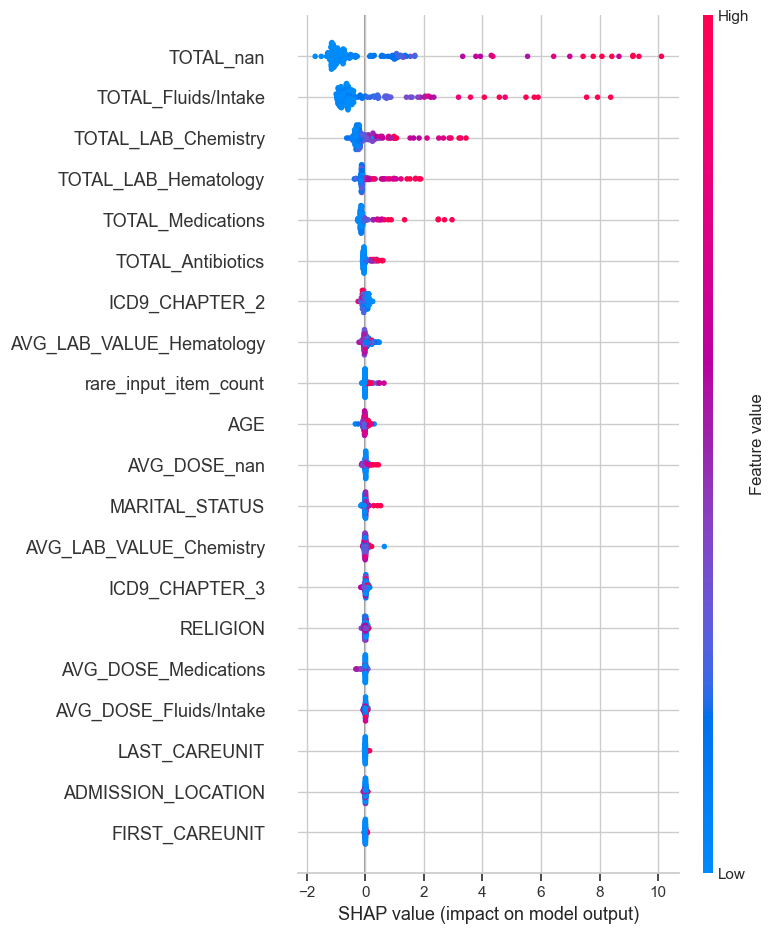

In [111]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

explainer_rf = shap.Explainer(rf_model, X_train)
shap_values_rf = explainer_rf(X_test)

shap.summary_plot(shap_values_rf, X_test)

shap_importance_rf = np.abs(shap_values_rf.values).mean(axis=0)
feature_importance_rf = pd.Series(shap_importance_rf, index=X_test.columns).sort_values(ascending=False)

A análise SHAP revelou os seguintes insights sobre o modelo de Random Forest:  

- **Testes laboratoriais** têm uma influência significativamente maior nas previsões do modelo em comparação com características demográficas.  
- **Quantidades elevadas de testes realizados** estão associadas a um tempo de internação mais prolongado.  

Isso sugere que variáveis clínicas (como exames médicos) são mais determinantes para prever o tempo de hospitalização do que fatores demográficos como idade ou gênero.

De seguida, gerámos a curva de cotovelo (elbow curve) para visualizar a importância cumulativa das variáveis no modelo de Random Forest, com base nos valores SHAP.

1. Cálculo da importância dos atributos: Extrair a média dos valores absolutos SHAP e ordenar os atributos por importância decrescente.
2. Cálculo da importância cumulativa: Soma progressiva das importâncias e divisão pelo total para obter proporção acumulada.
3. Desenho da curva com uma linha a realçar a 95% de importância.

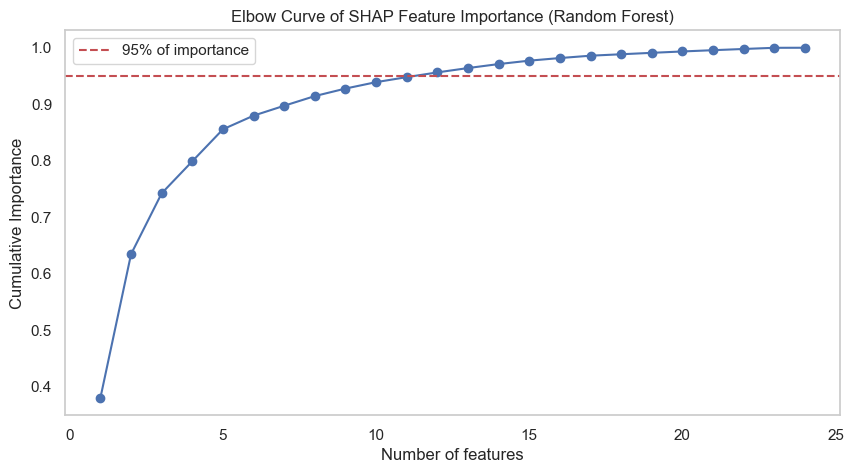

In [112]:
importances = np.abs(shap_values_rf.values).mean(axis=0)
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
cumulative = np.cumsum(sorted_importances) / np.sum(sorted_importances)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative)+1), cumulative, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% of importance')
plt.xlabel("Number of features")
plt.title("Elbow Curve of SHAP Feature Importance (Random Forest)")
plt.ylabel("Cumulative Importance")
plt.legend()
plt.grid()
plt.show()

In [113]:
n_selected_rf = np.argmax(cumulative >= 0.95) + 1
print(f"Númedo de atributos para atingir 95% da importância total de SHAP: {n_selected_rf}")
selected_features_rf = feature_importance_rf.head(n_selected_rf).index.tolist()
print("\n🔝 Atributos selecionádos para Random Forest:")
for atr in selected_features_rf:
    print("    ", atr)

Númedo de atributos para atingir 95% da importância total de SHAP: 12

🔝 Atributos selecionádos para Random Forest:
     TOTAL_nan
     TOTAL_Fluids/Intake
     TOTAL_LAB_Chemistry
     TOTAL_LAB_Hematology
     TOTAL_Medications
     TOTAL_Antibiotics
     ICD9_CHAPTER_2
     AVG_LAB_VALUE_Hematology
     rare_input_item_count
     AGE
     AVG_DOSE_nan
     MARITAL_STATUS


De seguida, vamos modelar os dados usando Random Forest tendo em atenção:

1. **Otimização de Hiperparâmetros**  
   Realiza um *Grid Search* com validação cruzada (CV=5) para encontrar os melhores valores para max_depth e n_estimators.  

2. **Seleção de Features**  
   Filtra os dados de treino e teste usando apenas os atributos mais relevantes, identificadas anteriormente.  

3. **Treino do Modelo Otimizado**  
   Cria e treina o modelo com os melhores parâmetros encontrados.  

4. **Avaliação de Desempenho**  
   Calcula métricas de regressão (R², MSE, RMSE, MAE) para medir a qualidade das previsões no conjunto de teste.

In [158]:
param_grid = {
    'max_depth': [3, 5, 10],
    'n_estimators': [50, 100],
}
grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Melhores parâmetros:", grid.best_params_)

X_train_selected = X_train[selected_features_rf]
X_test_selected = X_test[selected_features_rf]

start_time_model = time.time()
best_params = grid.best_params_
rf_model = RandomForestRegressor(**best_params, random_state=42)
rf_model.fit(X_train_selected, y_train)
end_time_model = time.time()

preds = rf_model.predict(X_test_selected)

resultados_modelos['Random Forest'] = {
    'R² Score': r2_score(y_test, preds),
    'MSE': mean_squared_error(y_test, preds),
    'RMSE': np.sqrt(mean_squared_error(y_test, preds)),
    'MAE': mean_absolute_error(y_test, preds),
    'TIME': end_time_model - start_time_model
}

Melhores parâmetros: {'max_depth': 10, 'n_estimators': 50}


### b. Gradient Boost

Implementamos um modelo de Gradient Boosting para regressão, e usámos a mesma pipeline com o SHAP para interpretar as previsões e avaliar a relevância das variáveis. O modelo foi treinado com os dados de entrada, aplicamos o shap aos valores do conjunto de teste, revelando o impacto individual de cada atributo e ilustrámos essas contribuições, ordenando a importância média dos atributos com base nos valores SHAP absolutos.

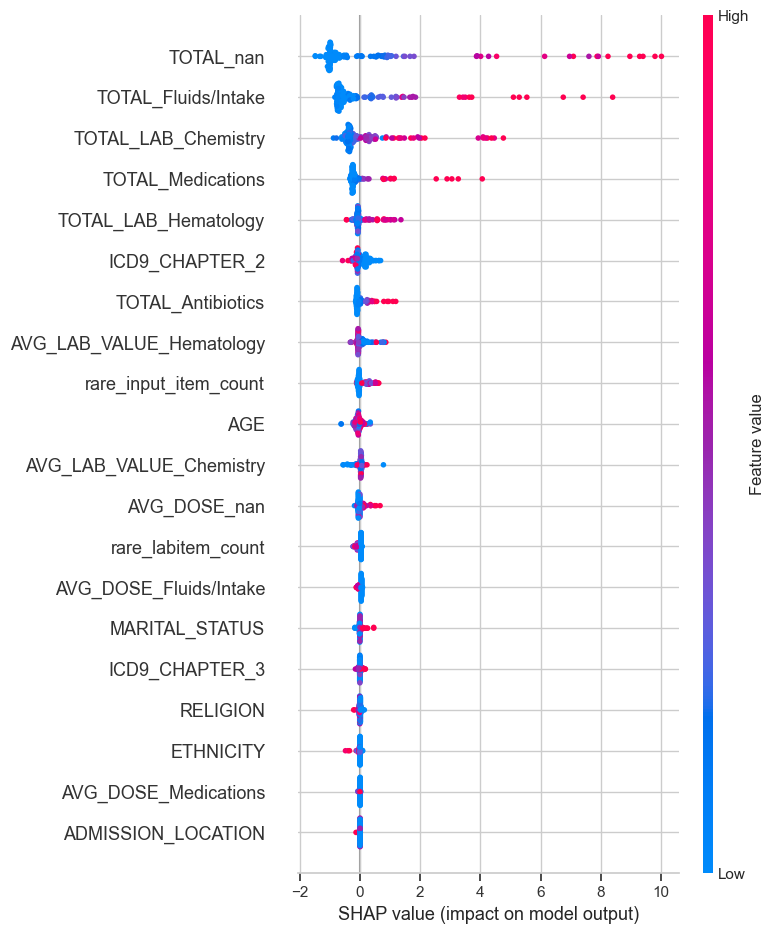

In [ ]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

explainer_gb = shap.Explainer(gb_model, X_train)
shap_values_gb = explainer_gb(X_test)

shap.summary_plot(shap_values_gb, X_test)

shap_importance_gb = np.abs(shap_values_gb.values).mean(axis=0)
feature_importance_gb = pd.Series(shap_importance_gb, index=X_test.columns).sort_values(ascending=False)

A análise SHAP revelou, tal como no modelo de Random Forest que:

- **Testes laboratoriais** têm uma influência significativamente maior nas previsões do modelo em comparação com características demográficas.  
- **Quantidades elevadas de testes realizados** estão associadas a um tempo de internação mais prolongado.  

De seguida, gerámos a curva de cotovelo (elbow curve) para visualizar a importância cumulativa das variáveis no modelo de Gradient Boosting, com base nos valores SHAP.

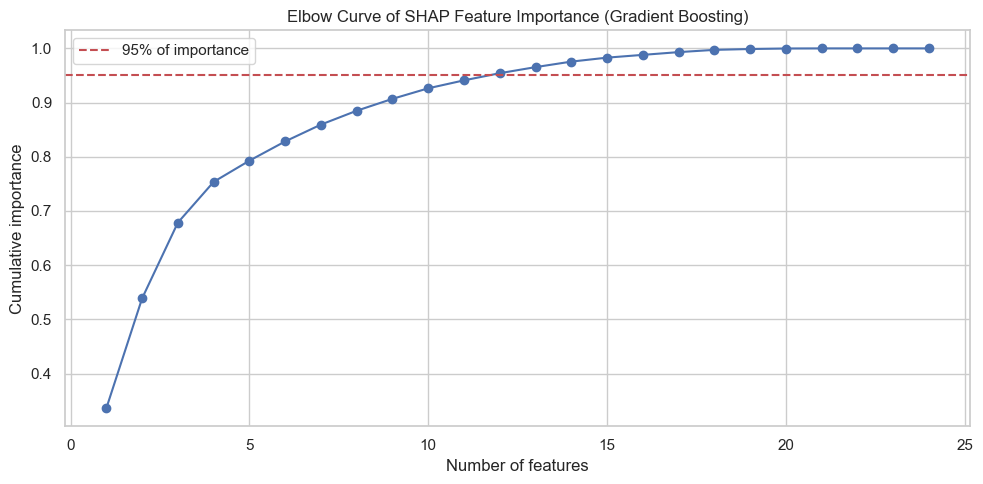

In [ ]:
importances = np.abs(shap_values_gb.values).mean(axis=0)
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
cumulative = np.cumsum(sorted_importances) / np.sum(sorted_importances)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative) + 1), cumulative, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% of importance')
plt.xlabel("Number of features")
plt.ylabel("Cumulative importance")
plt.title("Elbow Curve of SHAP Feature Importance (Gradient Boosting)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
n_selected_gb = np.argmax(cumulative >= 0.95) + 1
print(f"Númedo de atributos para atingir 95% da importância total de SHAP: {n_selected_gb}")
selected_features_gb = feature_importance_gb.head(n_selected_gb).index.tolist()
print("\n🔝 Atributos selecionádos para Gradient Boosting:")
for atr in selected_features_gb:
    print("    ", atr)

Númedo de atributos para atingir 95% da importância total de SHAP: 12

🔝 Atributos selecionádos para Gradient Boosting:
     TOTAL_nan
     TOTAL_Fluids/Intake
     TOTAL_LAB_Chemistry
     TOTAL_Medications
     TOTAL_LAB_Hematology
     ICD9_CHAPTER_2
     TOTAL_Antibiotics
     AVG_LAB_VALUE_Hematology
     rare_input_item_count
     AGE
     AVG_LAB_VALUE_Chemistry
     AVG_DOSE_nan


De seguida, vamos modelar os dados usando Gradient Boosting, com o seguinte processo:  

1. **Otimização de Hiperparâmetros**  
   Realiza um *Grid Search* com validação cruzada (CV=5) para otimizar três parâmetros: max_depth, n_estimators e learning_rate.  

2. **Seleção de Features**  
   Filtra os conjuntos de treino e teste utilizando apenas as variáveis mais relevantes.  

3. **Treino do Modelo Otimizado**  
   Cria e treina o modelo de Gradient Boosting com os melhores hiperparâmetros encontrados.  

4. **Avaliação de Desempenho**  
   Calcula métricas de regressão (R², MSE, RMSE, MAE) para medir a qualidade das previsões no conjunto de teste.

In [ ]:
X_train_selected = X_train[selected_features_gb]
X_test_selected = X_test[selected_features_gb]

param_grid_gb = {
    'max_depth': [3, 5, 10],
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1, 0.2]
}


grid_gb = GridSearchCV(GradientBoostingRegressor(), param_grid_gb, cv=5)
grid_gb.fit(X_train_selected, y_train)
print("Melhores parâmetros (Gradient Boosting):", grid_gb.best_params_)

start_time_model = time.time()
best_params_gb = grid_gb.best_params_
gb_model = GradientBoostingRegressor(**best_params_gb, random_state=42)
gb_model.fit(X_train_selected, y_train)
end_time_model = time.time()

gb_preds = gb_model.predict(X_test_selected)

resultados_modelos['Gradient Boosting'] = {
    'R² Score': r2_score(y_test, gb_preds),
    'MSE': mean_squared_error(y_test, gb_preds),
    'RMSE': np.sqrt(mean_squared_error(y_test, gb_preds)),
    'MAE': mean_absolute_error(y_test, gb_preds),
    'TIME': end_time_model - start_time_model
}

Melhores parâmetros (Gradient Boosting): {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}


### c. Neural Networks

Implementámos um modelo de Rede Neural (MLP) para regressão, aplicando a mesma abordagem com SHAP para interpretação. O modelo foi treinado com os dados de entrada (X_train, y_train), e utilizámos o KernelExplainer (devido à natureza não-linear das redes neurais) para calcular os valores SHAP em uma amostra do conjunto de teste. De seguida, gerámos a visualização das contribuições individuais das variáveis, enquanto a importância média é calculada com base nos valores SHAP absolutos e ordenada de forma decrescente.

100%|██████████| 100/100 [00:13<00:00,  7.35it/s]


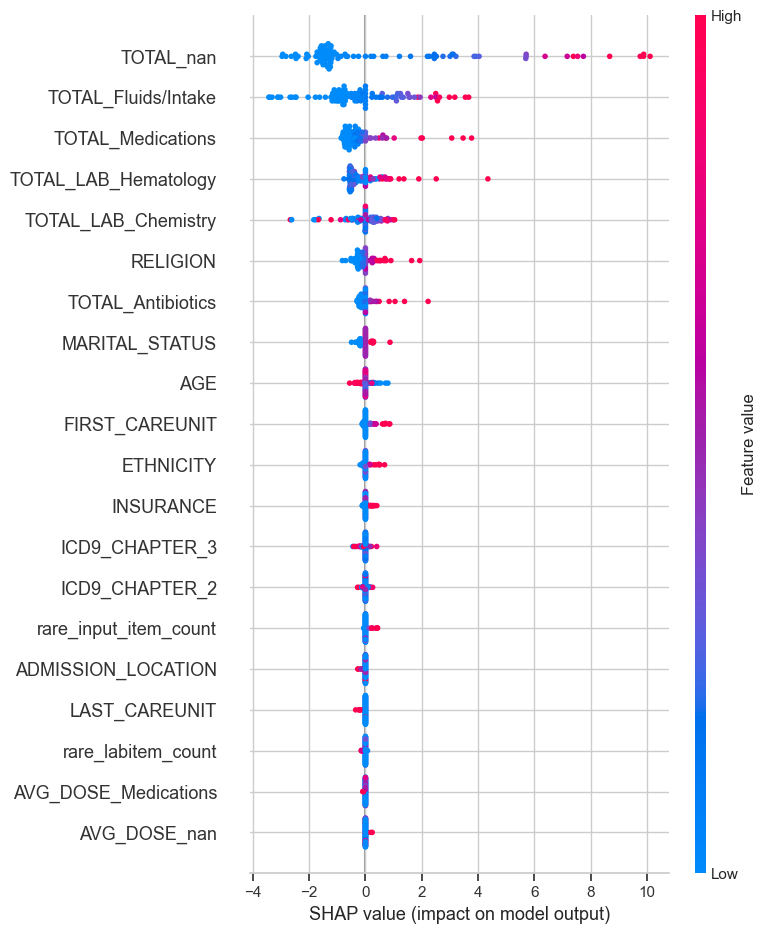

In [ ]:
nn_model = MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
nn_model.fit(X_train, y_train)

sampled_X_train = shap.sample(X_train, 100, random_state=42)
explainer_nn = shap.KernelExplainer(nn_model.predict, sampled_X_train)

shap_values_nn = explainer_nn.shap_values(X_test.iloc[:100])

shap.summary_plot(shap_values_nn, X_test.iloc[:100])

shap_importance_nn = np.abs(shap_values_nn).mean(axis=0)
feature_importance_nn = pd.Series(shap_importance_nn, index=X_test.columns).sort_values(ascending=False)

A análise SHAP revelou, tal como nos modelos anteriores que:

- **Testes laboratoriais** têm uma influência significativamente maior nas previsões do modelo em comparação com características demográficas.  
- **Quantidades elevadas de testes realizados** estão associadas a um tempo de internação mais prolongado.  

De seguida, gerámos a curva de cotovelo (elbow curve) para visualizar a importância cumulativa das variáveis no modelo de Rede Neuronal, com base nos valores SHAP.

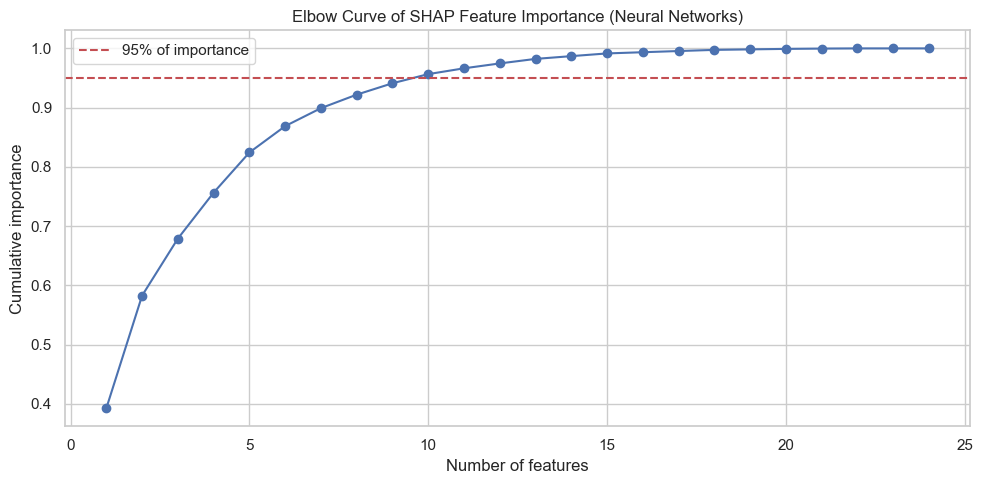

In [ ]:
importances = np.abs(shap_values_nn).mean(axis=0)
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
cumulative = np.cumsum(sorted_importances) / np.sum(sorted_importances)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative) + 1), cumulative, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% of importance')
plt.xlabel("Number of features")
plt.ylabel("Cumulative importance")
plt.title("Elbow Curve of SHAP Feature Importance (Neural Networks)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
n_selected_nn = np.argmax(cumulative >= 0.95) + 1
print(f"Númedo de atributos para atingir 95% da importância total de SHAP: {n_selected_nn}")
selected_features_nn = feature_importance_nn.head(n_selected_nn).index.tolist()
print("\n🔝 Atributos selecionádos para Gradient Boosting:")
for atr in selected_features_nn:
    print("    ", atr)

Númedo de atributos para atingir 95% da importância total de SHAP: 10

🔝 Atributos selecionádos para Gradient Boosting:
     TOTAL_nan
     TOTAL_Fluids/Intake
     TOTAL_Medications
     TOTAL_LAB_Hematology
     TOTAL_LAB_Chemistry
     RELIGION
     TOTAL_Antibiotics
     MARITAL_STATUS
     AGE
     FIRST_CAREUNIT


De seguida, vamos modelar os dados usando Neural Networks, com o seguinte processo:  

1. **Otimização de Hiperparâmetros**  
   Realiza um *Grid Search* com validação cruzada (CV=5) para otimizar arquitetura da rede (hidden_layer_sizes), função de ativação (relu, tanh), regularização (alpha), taxa de aprendizagem (learning_rate_init) e épocas de treino (max_iter).  

2. **Pré-processamento e Seleção de Features**  
   - Filtra os conjuntos de treino e teste usando apenas as variáveis mais relevantes.  
   - Aplica *StandardScaler* para normalizar os dados, essencial para redes neurais.  

3. **Treino do Modelo Otimizado**  
   Cria e treina a rede neural com os melhores hiperparâmetros identificados.  

4. **Avaliação de Desempenho**  
   Calcula métricas de regressão (R², MSE, RMSE, MAE) para medir a qualidade das previsões no conjunto de teste.

In [ ]:
X_train_selected = X_train[selected_features_nn]
X_test_selected = X_test[selected_features_nn]

param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01], 
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [500, 1000]
}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

grid_nn = GridSearchCV(MLPRegressor(random_state=42), 
                      param_grid_nn, 
                      cv=5,
                      n_jobs=-1, 
                      verbose=1)  

grid_nn.fit(X_train_scaled, y_train)
print("\nMelhores parâmetros (Neural Network):", grid_nn.best_params_)

start_time_model = time.time()
best_params_nn = grid_nn.best_params_
nn_model = MLPRegressor(**best_params_nn, random_state=42)
nn_model.fit(X_train_scaled, y_train)
end_time_model = time.time()

nn_preds = nn_model.predict(X_test_scaled)

resultados_modelos['Redes Neuronais'] = {
    'R² Score': r2_score(y_test, nn_preds),
    'MSE': mean_squared_error(y_test, nn_preds),
    'RMSE': np.sqrt(mean_squared_error(y_test, nn_preds)),
    'MAE': mean_absolute_error(y_test, nn_preds),
    'TIME': end_time_model - start_time_model
}

Fitting 5 folds for each of 96 candidates, totalling 480 fits

Melhores parâmetros (Neural Network): {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 1000}


## **4.** Análise e interpretação

Para a análise dos resultados dos modelos, começámos por fazer a tabela comparativa das métricas de avaliação de modelos de regressão e o respetivo tempo de treino.

In [ ]:
df_resultados = pd.DataFrame.from_dict(resultados_modelos, orient='index')
print(df_resultados)

                   R² Score       MSE      RMSE       MAE      TIME
Random Forest      0.826559  3.443139  1.855570  1.166225  0.185286
Gradient Boosting  0.784223  4.283589  2.069683  1.294495  0.090710
Redes Neuronais    0.843629  3.104265  1.761892  1.156140  1.548839


**1. Comparação de Desempenho**  
- **R² Score**:  
  - Redes Neuronais têm o melhor R² (0.8436), seguido por Random Forest (0.8266) e Gradient Boosting (0.7842). Isso indica que as redes neurais capturam melhor a variância dos dados, mas a diferença para Random Forest é pequena (0.0170).  
  - Gradient Boosting ficou ligeiramente atrás, mas ainda dentro de um intervalo competitivo.  

- **Erros (MSE, RMSE, MAE)**:  
  - Redes Neuronais também lideram em MSE (3.1043) e RMSE (1.7619), confirmando sua superioridade na minimização de erros quadráticos.  
  - Random Forest tem o menor MAE (1.1662), indicando que, em média, seus erros absolutos são mais consistentes.  
  - Gradient Boosting apresenta os piores valores em todas as métricas de erro.  

**2. Tempo de Execução**  
- Gradient Boosting (0.0907s) e Random Forest (0.1853s) têm tempos de execução significativamente menores que Redes Neuronais (1.5488s), com esta última sendo cerca de 8x mais lenta.  

**3. Análise de Robustez**  
- **Random Forest**:  
  - Menor MAE e R² alto sugerem menor sensibilidade a outliers e boa generalização.  
  - Ideal para dados com ruído ou relações não lineares complexas.  
- **Redes Neuronais**:  
  - Excelente desempenho em métricas quadráticas (MSE/RMSE), mas MAE ligeiramente superior ao Random Forest pode indicar maior sensibilidade a outliers.  
- **Gradient Boosting**:  
  - Embora competitivo, está consistentemente atrás dos outros dois modelos em todas as métricas.  

Se a diferença de R² entre Redes Neuronais e Random Forest for estatisticamente insignificante, então, Random Forest seria preferido devido à simplicidade e velocidade.

- **Hipótese Nula (H₀)**:  
  *"Não há diferença significativa entre os R² scores dos dois modelos."*  
  (Ou seja, a diferença observada é devido ao acaso.)  

- **Hipótese Alternativa (H₁)**:  
  *"Há diferença significativa entre os R² scores dos dois modelos."*  

Para isto, precisamos de múltiplas avaliações de R² para cada modelo, então aplicamos validação cruzada com 7 partes (7-fold cross validation) no dataset completo. Com isso, obtemos a média, o desvio padrão e os valores individuais de R² através do cálculo do resultado das 7 partições.


In [ ]:
def evaluate_models(X, y, models, cv_folds=7):
    results = {}
    for model_name, model in models.items():
        r2_scores = cross_val_score(model, X, y, cv=cv_folds, scoring='r2')
        results[model_name] = {
            'r2_mean': np.mean(r2_scores),
            'r2_std': np.std(r2_scores),
            'r2_scores': r2_scores
        }
        print(f"{model_name}: R² médio = {results[model_name]['r2_mean']:.4f} (±{results[model_name]['r2_std']:.4f})")
    return results

Usamos os modelos de random forest e neural network previatente definidos, com os respetivos hiperparametros ajustados aos dados.

In [ ]:
models = {
    "Random Forest": rf_model,
    "Rede Neuronal": nn_model
}

In [ ]:
results = evaluate_models(X, y, models, cv_folds=7)

Random Forest: R² médio = 0.7909 (±0.0589)
Rede Neuronal: R² médio = 0.7430 (±0.0591)


Dado que temos apenas 7 valores de R² por modelo (devido ao 7-fold CV) e não sabe se a distribuição destes valores é normal, o que seria de mostrar apenas com 7 valores, e os resultados de R² é possivel parear o teste de Wilcoxon (não paramétrico) é a escolha mais robusta. Para além disso, se houver variações extremas em algum fold, este teste é menos sensível.

In [ ]:
r2_rf = results["Random Forest"]['r2_scores']
r2_nn = results["Rede Neuronal"]['r2_scores']

statistic, p_value = wilcoxon(r2_rf, r2_nn, alternative='two-sided')

print(f"Estatística de Wilcoxon: {statistic:.3f}, p-valor: {p_value:.3f}")

Estatística de Wilcoxon: 1.000, p-valor: 0.031


O teste estatístico com p-valor igual a 0.031, menor que 0.05, confirma que a Rede Neural supera significativamente a Random Forest na previsão do tempo de internamento (LOS), com R² mais alto e menores erros. Embora a RN seja 8.4x mais lenta, essa diferença é irrelevante no contexto clínico, onde a precisão é prioritária e a previsão não requer urgência.

Portanto, concluímos que a adoção da Rede Neuronal, cuja vantagem preditiva justifica seu custo computacional marginal, garante estimativas mais confiáveis para o planeamento do internato hospitalar na unidade de cuidados intensivos dos doentes com pneumonia.

## **5.** Conclusão

O presente trabalho teve como objetivo aplicar técnicas de machine learning para prever o tempo de internamento na Unidade de Cuidados Intensivos (UCI) de pacientes diagnosticados com pneumonia, utilizando dados clínicos reais provenientes do repositório MIMIC-III. Através de uma abordagem estruturada — incluindo EDA, pré-processamento e avaliação com diferentes algoritmos.

Na fase de EDA, procuramos através da visualização de gráficos perceber melhor a distribuição de certos dados e tirar pequenas conclusões especícas sobre os internados com pneumonia.

No pré-processamento dos dados enfrentámos alguns desafios devido a certas limitações nos dados e tivemos também de utilizar técnicas para diminuir o número de variáveis, dado o reduzido número de casos do nosso dataset. Sendo assim, optamos por utilizar variáveis demográficas, mas com enconding numérico e reduzimos o número de colunas dos items passando-os para as suas categorias.

Já na parte de aplicar os modelos e avaliá-los , destacaram-se as Redes Neuronais e a Random Forest pela sua capacidade de capturar relações complexas nos dados e apresentar boas métricas de desempenho. A análise de importância das variáveis, pelo SHAP também permitiu identificar fatores clínicos e demográficos com forte influência sobre o tempo de internamento. Juntando isso à escolha mais adequada dos hiperparâmetros obtivemos modelos mais alinhados com os dados.

Por fim, este estudo reforça o potencial do uso de machine learning na área da saúde, especialmente no apoio à gestão hospitalar e no planejamento de recursos, ao mesmo tempo em que evidencia a importância de uma base de dados bem estruturada e da compreensão clínica dos resultados para garantir aplicações práticas e eticamente responsáveis.